# Project Title (ADD)

-----------------

**Author:** Alec Reid 

**Student Number:** G00411003

**Date Commenced:** 05/01/26

-----------

**Licences and Rights**

Data used in this project was sourced from Met Éireann Irelands weather service. 

1. Copyright statement: Copyright Met Éireann
2. Source www.met.ie
3. Licence Statement: This data is published under a Creative Commons Attribution 4.0 International (CC BY 4.0). https://creativecommons.org/licenses/by/4.0/
4. Disclaimer: Met Éireann does not accept any liability whatsoever for any error or omission in the data, their availability, or for any loss or damage arising from their use.
5. Where applicable, an indication if the material has been modified and an indication of previous modifications

--------

**References:**

Move to bibolography at end 

- (https://www.met.ie/climate/available-data/historical-data)
- Source for optimal wind speeds https://greenbusinessbarbados.com/what-wind-speed-is-best-for-turbine-efficiency.html
- Wind Speed Thresholds https://www.cedengineering.com/userfiles/R06-004%20-%20Wind%20Energy%20Design%20and%20Fundamentals%20-%20US.pdf?utm_source=chatgpt.com

-------------

#### Table of Contents 

Add


-----------------

## 1. Introduction
### 1.2 Objectives and Research Questions
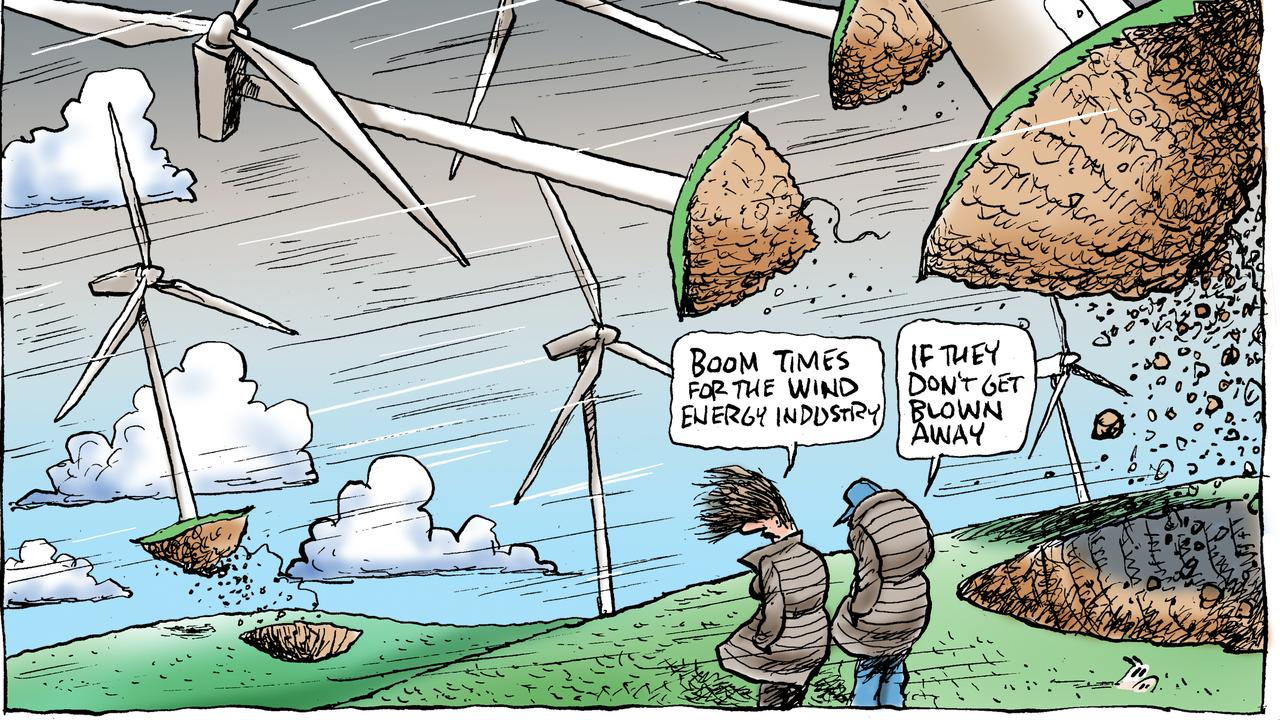 

The research question is simply to determine if using publically available wind speed data we can make an assumption on a given locations suitability to host a windfarm. Where it is assumed that a 'suitable' location is a location that gets enough wind to produce consitent energy without suffering exstenive downtimes or a high liklyhood of damage owing to extrem weather. 

### 1.3 Scope and Assumptions
#### (1.3.1) Scope
The scope of this project includes:
- Analysis of historical wind speed data sourced primarily from publically availabe (Met Éireann) weather stations.
- Temporal analysis covering hourly, daily, monthly, and yearly aggregations.
- Use of simplified wind turbine model to estimate potential power output.

#### (1.3.2) Assumptions
The following assumptions are made in this analysis:
- Weather station data is representative of broader regional wind conditions.
- Wind speed measurements are accurate and consistent across time and locations.
- Turbine specifications are assumed to be constant.
- Effects of terrain, wake losses, turbine degradation, urban areas and grid constraints are not considered.

-----------


## 2. Data Sources and Acquisition

### 2.1 Looking at the Weather Stations - Seeing What Data is Available 


Met Eireann have a good spatial distribution of weather stations across the country with publically accessibly data. They have a csv of all the stations that we can explore to find out more.

In [1]:
#Imports
import zipfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os as os

In [2]:
# Read the CSV file, skipping problematic rows as there was some trouble with bad lines 
StationData = pd.read_csv(r'C:\AlecProjects\PFDA_2025_Project-\StationDetails.csv', on_bad_lines='skip')

# Display the first few rows of the dataframe
print(StationData.head())

   county  station name                    name  height(m)  easting  northing  \
0  Antrim          5880         LH_RATHLIN_WEST         10   309200    451800   
1  Carlow          4415     TULLOW (Waterworks)         76   284700    173400   
2  Carlow          2414             BORRIS G.S.         85   272400    150700   
3  Carlow          1214  CARLOW (SUGAR FACTORY)         58   272200    178400   
4  Carlow           115     HACKETSTOWN RECTORY        182   297600    180500   

   latitude  longitude open year close year  
0  55.30083   -6.28028      2000     (null)  
1  52.80528   -6.74306      1985     (null)  
2  52.60278   -6.93056      1944       1991  
3  52.85139   -6.92778      1953       1960  
4  52.86667   -6.55000      1910       1944  


In [3]:
# Have a look at headers
print(StationData.columns)

Index(['county', 'station name', 'name', 'height(m)', 'easting', 'northing',
       'latitude', 'longitude', 'open year', 'close year'],
      dtype='object')


In [4]:
unique_station_names = StationData['station name'].nunique()
print(f"Number of unique station names: {unique_station_names}")

Number of unique station names: 2080


**Drawbacks** 
- I was hoping it the csv on station data would include a heading which outlined the paramters the station recorded - then we could have filtered out the stations not looking at wind.
- I was also hoping it would show the temporal resolution of each station so we could filter out any station that didn't give an hourly resolution.

**Soloution**

Luckily the MetEireann website is interactive so I can use it to refine my search to include only stations with hourly resolution. At this level of resolution only seems to be availble in the principal weather stations around the country. I refined this further to exclude and station that was not operational pre 2025 as we want at least 20 years of hindcast data to look at. This left me with eight stations with a good spatial distribution around the country so these are what we are going to use. I got the 8 station IDs from MET Eireann website so I can filter out there broad data using these:

In [5]:
# Filter the rows for the specified station names
filtered_stations = StationData[StationData['station name'].isin([275, 375, 575, 675, 775, 875, 1275, 1975])]

# Display the filtered rows
print(filtered_stations)

         county  station name           name  height(m)  easting  northing  \
15       Carlow           375       OAK PARK         62   273000    179500   
43        Cavan           675     BALLYHAISE         78   245200    311600   
223        Cork           775  SherkinIsland         21   100781     25801   
366        Cork           575     MOORE PARK         46   181900    101400   
740      Galway           275      MACE HEAD         21    73400    232276   
1573  Roscommon          1975      MT DILLON         39   201306    275240   
1598      Sligo          1275        MARKREE         34   169860    325582   
1851  Westmeath           875      MULLINGAR        101   243000    254300   

      latitude  longitude open year close year  
15    52.86111   -6.91528      2003     (null)  
43    54.05139   -7.30972      2003     (null)  
223   51.47639   -9.42778      2004     (null)  
366   52.16389   -8.26389      2003     (null)  
740   53.32583   -9.90083      2003     (null)  
157

Looks pretty good, good spatial distribtion across the counties - the only stations which might be outliers due to their elevation are those in Westmeath, Cavan and Carlow - but the other stations are located more westerly which get good and crazy winds as well so I think it balances out (for this basic exercise at least)

### (2.2)Mapping Stations: Filtering out Northing and Eastings 

We'll do this so we can export it as a csv and plot the points in QGIS to see how it looks on a map. (Could just )

In [6]:
# Display only the easting northings (I am going to plug these into QGIS to get a visual idea of where these stations are)
filtered_stations_subset = filtered_stations[['station name', 'easting', 'northing']]
print(filtered_stations_subset)

# Export as sperate CSV 
filtered_stations_subset.to_csv(r'C:\AlecProjects\PFDA_2025_Project-\StationDetailsEastingNorthings.csv', index=False)


      station name  easting  northing
15             375   273000    179500
43             675   245200    311600
223            775   100781     25801
366            575   181900    101400
740            275    73400    232276
1573          1975   201306    275240
1598          1275   169860    325582
1851           875   243000    254300


**Spatial Distribution of Staions** 

Add map using QGIS 

**Description of how I got the Data**

I downloaded the following data for the stations we are going to look at in this project (all data is sourced from MetEireann):
- All weather parameters available.
- Hindcast data for last 20 years.(2005 - 2025)
- Hourly, Daily and Monthly intervals.


------------------

##  (3) Monthly Data Exploration and Analysis ( Example Site: Mace Head_Station 275)

We'll use station 275 as a guine pig to get an idea of what the monthly files look like and what analysis we can perform.

#### (3.1) Monthly Data - Station 275 Initial Inspection and Cleaning

In [7]:
# Load the file 
file_path = r'C:\AlecProjects\PFDA_2025_Project-\Monthly All Stations\mly275.csv'

with open(file_path, 'r', encoding='utf-8') as f:
    for i in range(19):
        print(f"{i+1}: {f.readline().rstrip()}")

1: Station Name: MACE HEAD
2: Station Height: 21 M
3: Latitude:53.326  ,Longitude: -9.901
4: 
5: 
6: year:  -  Year
7: month: -  Month
8: rain:  -  Precipitation Amount (mm)
9: meant: -  Mean Air Temperature (C)
10: maxtp: -  Maximum Air Temperature (C)
11: mintp: -  Minimum  Air Temperature (C)
12: mnmax: -  Mean Maximum Temperature (C)
13: mnmin: -  Mean Minimum Temperature (C)
14: gmin:  -  Grass Minimum Temperature (C)
15: wdsp:  -  Mean Wind Speed (knot)
16: mxgt:  -  Highest Gust (knot)
17: sun:   -  Sunshine duration (hours)
18: ind:   -  Indicator
19: 


**Comment:** No actually weather data in first 23 rows, but it shows us the key for what each abreviation indicates which is useful; looks like we are going to be interested in the following few;
- wdsp:  -  Mean Wind Speed (knot)
- mxgt:  -  Highest Gust (knot)
- We can skip to row 20 to look at the acutual weather data 

In [8]:
# Skip to row 20 as this is where the data headings start
data275 = pd.read_csv(file_path, skiprows=19)

# Display the first few rows of the loaded data
print(data275.head(24))

    year  month meant maxtp mintp mnmax mnmin   rain  gmin  wdsp  maxgt sun
0   2003     11   9.7  16.0   2.8  11.8   7.6  128.1   0.1  17.6     60    
1   2004      1   7.1  11.6  -0.3   9.4   4.9  141.7  -3.1  16.2     64    
2   2004      2   6.5  12.3  -0.9   9.0   4.1         -3.6  13.1     54    
3   2004      3   7.8  13.5   1.6  10.2   5.4         -3.0  16.0     69    
4   2004      4   9.4  14.1   2.1  11.8   7.0   73.1  -0.7  15.1     58    
5   2004      5  11.7  19.2   5.8  14.4   9.1   27.8   0.8  12.3     58    
6   2004      6  13.9  20.8   8.3  16.1  11.7   59.9   3.0  14.2     43    
7   2004      8  15.7  21.8   9.2  18.4  13.0          6.6  12.2     44    
8   2004      9  14.3  22.7   7.9  16.3  12.3   85.2   4.9  18.1     55    
9   2004     10   9.9  14.7   2.5  12.4   7.4  120.0   2.6  14.8     52    
10  2004     11   9.7  12.4   1.1  11.2   8.3   57.5  -1.4  14.2     46    
11  2004     12   8.4  12.0   1.0  10.3   6.5  101.2  -2.2  19.0     57    
12  2005    

In [9]:
# Check the distribution of the 'year' column (We can do this to see the amount of entries for a given year - so we know if it doesn't occur 12 times it is missing a month)
print("\nYear Distribution:")
print(data275['year'].value_counts().sort_index())


Year Distribution:
year
2003     1
2004    11
2005    11
2006    12
2007    10
2008    12
2009    12
2010    12
2011    12
2012    12
2013    12
2014    12
2015    12
2016    12
2017    12
2018    12
2019    12
2020    12
2021    12
2022    12
2023    12
2024    12
2025    11
Name: count, dtype: int64


**Comment:** Some years are incomplete (2003,2004,2005,2007,2025)

In [10]:
# Keep only the columns for wind parameters and their corresponding monthand year
WindOnlyCols = ["year", "month", "wdsp", "maxgt"]
WindOnly = data275[WindOnlyCols]

#Check
print("\nWind Data Subset:")
print(WindOnly.head(20))


Wind Data Subset:
    year  month  wdsp  maxgt
0   2003     11  17.6     60
1   2004      1  16.2     64
2   2004      2  13.1     54
3   2004      3  16.0     69
4   2004      4  15.1     58
5   2004      5  12.3     58
6   2004      6  14.2     43
7   2004      8  12.2     44
8   2004      9  18.1     55
9   2004     10  14.8     52
10  2004     11  14.2     46
11  2004     12  19.0     57
12  2005      1  15.0     73
13  2005      2  12.8     54
14  2005      3  13.0     40
15  2005      5  13.4     47
16  2005      6  11.5     35
17  2005      7  11.5     45
18  2005      8  12.2     48
19  2005      9  15.6     47


**Comment** Lets convert the any empty values to numeric nulls and filter these out

In [14]:
# Make sure the data types are numeric for dropping nulls
cols = ["year", "month", "wdsp", "maxgt"]

WindOnlyNoNulls = (
    WindOnly
    .assign(
        year=lambda d: pd.to_numeric(d["year"], errors="coerce"),
        month=lambda d: pd.to_numeric(d["month"], errors="coerce"),
        wdsp=lambda d: pd.to_numeric(d["wdsp"], errors="coerce"),
        mxgt=lambda d: pd.to_numeric(d["maxgt"], errors="coerce"),
    )
    .dropna(subset=cols)
)

#Now drop the nulls for wind data only
WindOnlyNoNulls = WindOnly.dropna()

In [15]:
# Check Shape to see if any dropped
print("Before:", WindOnly.shape)
print("After:", WindOnlyNoNulls.shape)

print(WindOnlyNoNulls.isna().sum())

Before: (260, 4)
After: (260, 4)
year     0
month    0
wdsp     0
maxgt    0
dtype: int64


**Comment** Looks like nothing was dropped - a bit suspicious of that, but 'I'm going to presume its right because we did the conversion to numeric. For total accuracy we probably should have filtetred out any incomplete years (maybe a job for the future if we come back to this).

#### (3.2) Making Quarters to Divide the Months Up For Easier Analysis

**Comment** By creating quarters we can plot the data easier and identify which sections of the year have the most optimal and least optimal production winds.

In [18]:
# Keep only the relevant columns (make a copy to avoid SettingWithCopyWarning)
df = WindOnlyNoNulls.copy()

# Force numeric types (I don't knwo why I had to force numeric again but it was only way to get this cell to run)
df["wdsp"] = pd.to_numeric(df["wdsp"], errors="coerce")
df["maxgt"] = pd.to_numeric(df["maxgt"], errors="coerce")

# Drop rows where conversion failed
df = df.dropna(subset=["wdsp", "maxgt"])

# Create a quarter column
df["quarter"] = np.select(
    [
        df["month"].between(1, 3),
        df["month"].between(4, 6),
        df["month"].between(7, 9),
        df["month"].between(10, 12)
    ],
    ["Q1(Jan-Mar)", "Q2(Apr-Jun)", "Q3(Jul-Sep)", "Q4(Oct-Dec)"],
    default=np.nan
)

# Group by year and quarter and calculate means
quarterly_means = (
    df
    .groupby(["year", "quarter"], as_index=False)
    .agg(
        mean_wdsp=("wdsp", "mean"),
        mean_maxgt=("maxgt", "mean")
    )
)

print(quarterly_means)


    year      quarter  mean_wdsp  mean_maxgt
0   2003  Q4(Oct-Dec)  17.600000   60.000000
1   2004  Q1(Jan-Mar)  15.100000   62.333333
2   2004  Q2(Apr-Jun)  13.866667   53.000000
3   2004  Q3(Jul-Sep)  15.150000   49.500000
4   2004  Q4(Oct-Dec)  16.000000   51.666667
..   ...          ...        ...         ...
84  2024  Q4(Oct-Dec)  14.866667   68.666667
85  2025  Q1(Jan-Mar)  14.666667   67.666667
86  2025  Q2(Apr-Jun)  12.333333   42.333333
87  2025  Q3(Jul-Sep)  14.433333   49.333333
88  2025  Q4(Oct-Dec)  16.550000   63.500000

[89 rows x 4 columns]


##### (3.2.1) Look at quarterly performance over 5 Years 2020-2025

Thresholds for the values we want to look at using established wind turbine site survying:

These thresholds were sourced from: https://www.cedengineering.com/userfiles/R06-004%20-%20Wind%20Energy%20Design%20and%20Fundamentals%20-%20US.pdf?utm_source=chatgpt.com

**Wind Speeds Thresholds**

| Turbine Stage                 | Wind Speed (m/s) | Wind Speed (knots) | Meaning                         |
| ----------------------------- | ---------------- | ------------------ | ------------------------------- |
| **Cut-in speed**              | 3–4 m/s          | **6–8 knots**      | Turbine starts generating power |
| **Optimal / Efficient range** | 7–12 m/s         | **14–23 knots**    | Best energy production          |
| **Rated speed**               | 12–15 m/s        | **23–29 knots**    | Maximum (rated) power output    |
| **Cut-out speed**             | ~25 m/s          | **≈49 knots**      | Turbine shuts down for safety   |

**Wind Gust Thresholds**

| Gust Category                    | Wind Gust (knots) | Wind Gust (m/s) | Operational Significance                                  |
| -------------------------------- | ----------------- | --------------- | --------------------------------------------------------- |
| **Normal operating gusts**       | < **35 kt**       | < ~18 m/s       | Safe for normal turbine operation                         |
| **High but acceptable gusts**    | **35–45 kt**      | ~18–23 m/s      | Increased mechanical loading; turbines continue operating |
| **Near cut-out conditions**      | **45–49 kt**      | ~23–25 m/s      | Turbine control systems actively limit loads              |
| **Cut-out / shutdown gusts**     | **≥ 49 kt**       | ≥ ~25 m/s       | Turbines shut down to prevent damage                      |
| **Extreme gusts (storm events)** | **≥ 60 kt**       | ≥ ~31 m/s       | Structural design limit; no operation                     |




In [20]:
# Filter quarterly means for years 2019–2024 (5 complete years)
DataQuarterly2019_2024 = quarterly_means[
    (quarterly_means["year"] >= 2019) &
    (quarterly_means["year"] <= 2024)
]

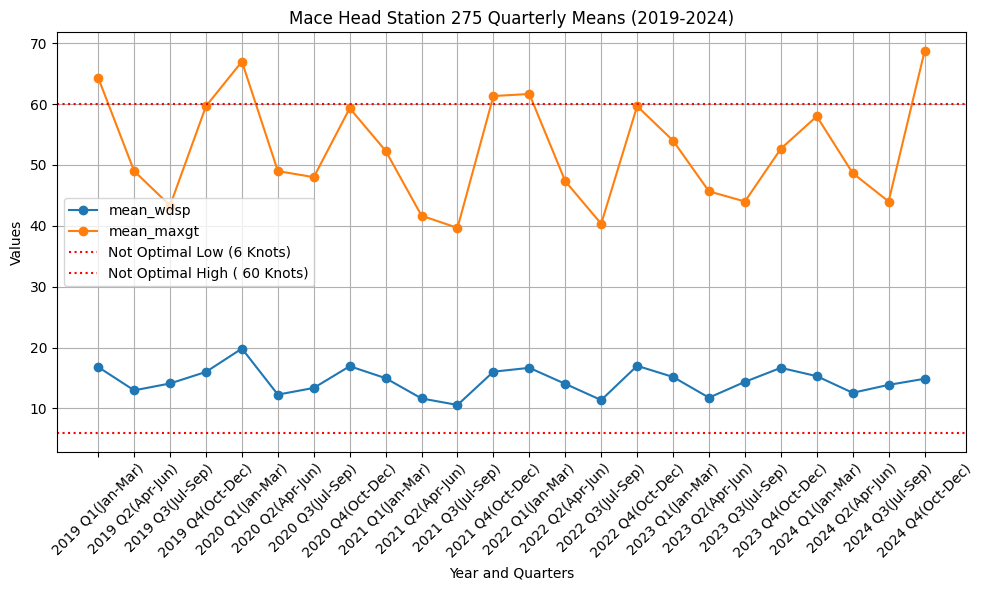

In [21]:
# Plot the data
plt.figure(figsize=(10, 6))
for column in ['mean_wdsp', 'mean_maxgt']:
    plt.plot(DataQuarterly2019_2024['year'].astype(str) + " " + DataQuarterly2019_2024['quarter'], 
             DataQuarterly2019_2024[column], 
             marker='o', 
             label=column)

# Add dotted red lines for 'Not Optimal Low' and 'Not Optimal High'
plt.axhline(y=6, color='red', linestyle='dotted', label='Not Optimal Low (6 Knots)')
plt.axhline(y=60, color='red', linestyle='dotted', label='Not Optimal High ( 60 Knots)')

#plot details
plt.title('Mace Head Station 275 Quarterly Means (2019-2024)')
plt.xlabel('Year and Quarters')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

**Comment** Mace head looks like a great site, but maybe :

- In the 5 year period from 2019 to 2024 it didn't experince any qurter below the not optimal low threshold of 6 knots
- Although it did experience 8 quarters where the mx gusts exceeded 60 knots so likly any turbines would have to be cut off during these stong wind events.

**Research Question for Later** We'll look at the daily data to identify how many days a potential wind farm could have been operational and when it would of had to been cut off. 

#### (3.2.1) Comparing the Overall Quarter Performances: Most Potential Production Per Year vs Most Potential Downtime per Year 

**Most Potential Wind Energy Production Per Year**

- The amount of occurances each quarter experinces the highest mean for wdsp of the year and w the lowest mean wdsp of the year.


In [22]:
# Identify the worst quarter for each year based on mean wind speed
LeastWdspQuarters = (
    quarterly_means
    .loc[
        quarterly_means.groupby("year")["mean_wdsp"].idxmin()
    ]
    .groupby("quarter")
    .size()
    .reset_index(name="Least")
    .sort_values("Least", ascending=False)
)

# Identify the best quarter for each year based on mean wind speed
MostWdspQuarters = (
    quarterly_means
    .loc[
        quarterly_means.groupby("year")["mean_wdsp"].idxmax()
    ]
    .groupby("quarter")
    .size()
    .reset_index(name="Most")
    .sort_values("Most", ascending=False)
)

# Quarter performance summary
quarter_performance = (MostWdspQuarters.merge(LeastWdspQuarters, on="quarter", how="outer").fillna(0))

# Show quarter performance
print(quarter_performance)



       quarter  Most  Least
0  Q4(Oct-Dec)  14.0      1
1  Q1(Jan-Mar)   8.0      1
2  Q3(Jul-Sep)   1.0      6
3  Q2(Apr-Jun)   0.0     15


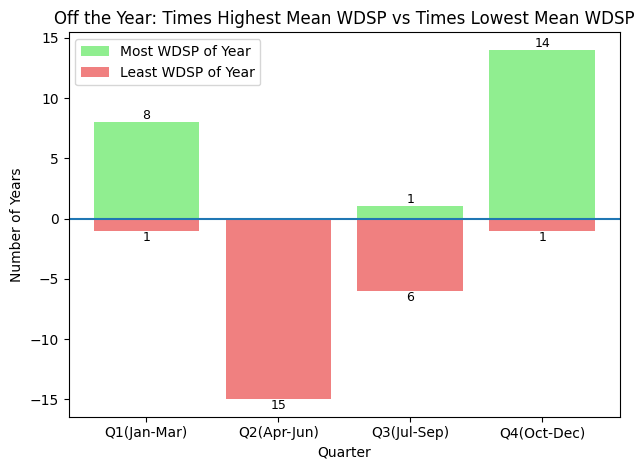

In [23]:
# Ensure quarters are in logical order
quarter_order = ["Q1(Jan-Mar)", "Q2(Apr-Jun)", "Q3(Jul-Sep)", "Q4(Oct-Dec)"]
quarter_performance["quarter"] = pd.Categorical(
    quarter_performance["quarter"],
    categories=quarter_order,
    ordered=True
)
quarter_performance = quarter_performance.sort_values("quarter")

# Numeric x positions
x = np.arange(len(quarter_performance))

plt.figure()

# Plot best quarters (positive)
plt.bar(
    x,
    quarter_performance["Most"],
    label="Most WDSP of Year", color='Lightgreen'
)

# Plot worst quarters (negative)
plt.bar(
    x,
    -quarter_performance["Least"],
    label="Least WDSP of Year", color='Lightcoral'
)

# Zero reference line
plt.axhline(0)

# Add value labels
for xi, best, worst in zip(
    x,
    quarter_performance["Most"],
    quarter_performance["Least"]
):
    if best > 0:
        plt.text(xi, best, f"{int(best)}", ha="center", va="bottom", fontsize=9, )
    if worst > 0:
        plt.text(xi, -worst, f"{int(worst)}", ha="center", va="top", fontsize=9,)

# Axis labels and ticks
plt.xticks(x, quarter_performance["quarter"])
plt.xlabel("Quarter")
plt.ylabel("Number of Years")
plt.title("Off the Year: Times Highest Mean WDSP vs Times Lowest Mean WDSP")
plt.legend()
plt.tight_layout()
plt.show()


**Comment** 
- Q1 and Q4 are most often top the highesht mean wdsp of a year.
- Q2 and Q3 experience the lowest mean wdsp of a year.
- This analysis is quite useful when considering what times of the year we would need to suppliment a windfarm at mace head with other energy sources (e.g coal power plant) **but** it would need to take into consideration when the most cut of times due to high gusts occur, becuase as we say earlier all quarters were idntified as sufficnet for wind energy production at Mace head so it may more be a question of which quarter experieces the least downtime as opposed to which quarter produces the most when operational. 

**Most Potential Downtime**

- The amount of occurances each quarter experinces the a mean for gusts of that exceeds the 60 nots limit.



In [24]:
# Calculate quarterly maximum gusts exceeding 60 kn
quarterly_means["mean_maxgt_exceed_60"] = (
    quarterly_means["mean_maxgt"] > 60
)

# Summarize the number of times each quarter exceeded 60 kn
quarter_exceed_summary = (
    quarterly_means
    .groupby("quarter")
    .agg(
        times_exceed_60=("mean_maxgt_exceed_60", "sum"),
        total_years=("year", "nunique")
    )
    .reset_index()
)

# Show the summary of quarters exceeding 60 kn
print(quarter_exceed_summary)


       quarter  times_exceed_60  total_years
0  Q1(Jan-Mar)               12           22
1  Q2(Apr-Jun)                0           22
2  Q3(Jul-Sep)                0           22
3  Q4(Oct-Dec)                8           23


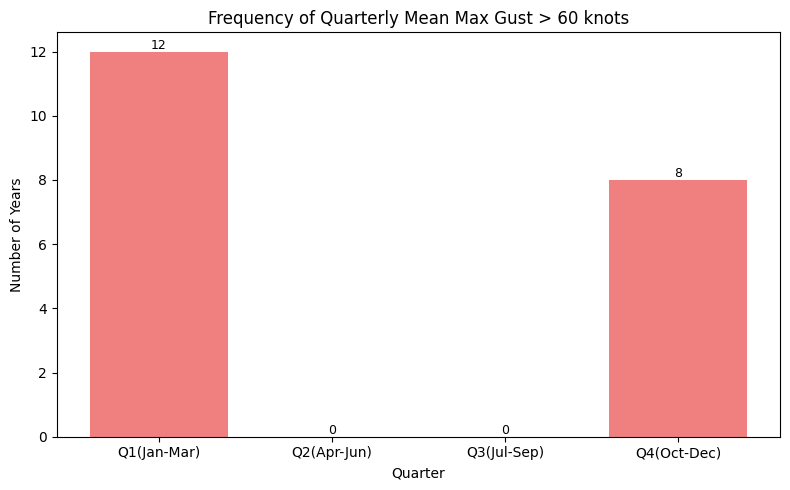

In [25]:
# Plot the frequency of quarters exceeding 60 kn
plt.figure(figsize=(8, 5))
bars = plt.bar(
    quarter_exceed_summary["quarter"],
    quarter_exceed_summary["times_exceed_60"],color='lightcoral'
)

# Add labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,height,f"{int(height)}",ha="center",va="bottom",fontsize=9)

# Plot details
plt.xlabel("Quarter")
plt.ylabel("Number of Years")
plt.title("Frequency of Quarterly Mean Max Gust > 60 knots")
plt.tight_layout()
plt.show()

**Comment** 
- Q1 has experience 12 occurances where the max mean quartetly gusts were over the 60 knots threshold and Q4 experienced 8; so we can assume any windfarm would have suffered a lot of downtime during these high mean quarters.
- Q2 and Q3 have never experienced a max mean quarterly gusts over the threshold so we can assume any windfarm wouldn't have suffered any downtime.

-----------------

### (4) Daily Data Exploration and Analysis ( Example Site: Mace Head_Station 275)

In [26]:
# Load the file 
file_path_275dl = r'C:\AlecProjects\PFDA_2025_Project-\Daily All Stations\dly275.csv'

with open(file_path_275dl, 'r', encoding='utf-8') as f:
    for i in range(21):
        print(f"{i+1}: {f.readline().rstrip()}")

1: Station Name: MACE HEAD
2: Station Height: 21 M
3: Latitude:53.326  ,Longitude: -9.901
4: 
5: 
6: date:  -  00 to 00 utc
7: rain:  -  Precipitation Amount (mm)
8: maxtp: -  Maximum Air Temperature (C)
9: mintp: -  Minimum  Air Temperature (C)
10: gmin:  -  09utc Grass Minimum Temperature (C)
11: soil:  -  Mean 10cm soil temperature (C)
12: cbl:   -  Mean CBL Pressure (hpa)
13: wdsp:  -  Mean Wind Speed (kt)
14: hm:    -  Highest ten minute mean wind speed (kt)
15: ddhm:  -  Wind Direction at max 10 min mean (deg)
16: hg:    -  Highest Gust (kt)
17: pe:    -  Potential Evapotranspiration (mm)
18: evap:  -  Evaporation (mm)
19: smd_wd:-  Soil Moisture Deficits(mm) well drained
20: smd_md:-  Soil Moisture Deficits(mm) moderately drained
21: smd_pd:-  Soil Moisture Deficits(mm) poorly drained


In [27]:
# Skip to row 22 as this is where the data headings start
data275_daily = pd.read_csv(file_path_275dl, skiprows=22)

# Display the first few rows of the loaded data
print(data275_daily.head(20))

                                                                                                                         ind:   -  Indicator (i)
date        ind maxtp ind mintp igmin gmin ind rain cbl    wdsp ind hm ind ddhm ind hg soil pe evap smd_wd smd_md smd_pd                  glorad
14-aug-2003 0   19.2  0   9.0              0   0.0  1020.2 6.7  0   13 0   60   0   17                                                      2432
15-aug-2003 0   19.3  0   11.2             0   0.0  1018.7 6.5  0   12 0   280  0   15                                                      2284
16-aug-2003 0   19.4  0   11.0             0   0.0  1015.6 5.7  0   10 0   200  0   13                                                      2084
17-aug-2003 0   17.0  0   14.4             0   3.3  1008.3 16.9 0   26 0   180  0   34                                                       954
18-aug-2003 0   17.1  0   13.1             0   0.2  1011.9 18.5 0   23 0   270  0   28                                            

In [28]:
# Read the CSV file directly specifying the header row #
data275_daily = pd.read_csv("C:\\AlecProjects\\PFDA_2025_Project-\\Daily All Stations\\dly275.csv", header=21)

# Chekc the columns
print(data275_daily.columns)

Index(['date', 'ind', 'maxtp', 'ind.1', 'mintp', 'igmin', 'gmin', 'ind.2',
       'rain', 'cbl', 'wdsp', 'ind.3', 'hm', 'ind.4', 'ddhm', 'ind.5', 'hg',
       'soil', 'pe', 'evap', 'smd_wd', 'smd_md', 'smd_pd', 'glorad'],
      dtype='object')


In [29]:
# Keep only the columns for wind parameters and their corresponding date
WindOnly = ["date", "wdsp", "hg"]

# Drop any null values and convert data types (converting date to datetime, wdsp and hg to numeric so they can be recognised as nulls if absent and for plotting later)
data_275dl_WindOnly = (
    data275_daily
    .assign(
        date=lambda d: pd.to_datetime(d["date"], errors="coerce"), # Change date to datetime format
        wdsp=lambda d: pd.to_numeric(d["wdsp"], errors="coerce"), # chnage wdsp to numeric
        hg=lambda d: pd.to_numeric(d["hg"], errors="coerce"), # change hg to numeric 
    )[WindOnly]
    .dropna(subset=["date", "wdsp", "hg"])
)

# Check
print("\nWind Data Subset:")
print(data_275dl_WindOnly.head(10))

C:\Users\Alec\AppData\Local\Temp\ipykernel_18380\1394238645.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date=lambda d: pd.to_datetime(d["date"], errors="coerce"), # Change date to datetime format



Wind Data Subset:
        date  wdsp    hg
0 2003-08-14   6.7  17.0
1 2003-08-15   6.5  15.0
2 2003-08-16   5.7  13.0
3 2003-08-17  16.9  34.0
4 2003-08-18  18.5  28.0
5 2003-08-19  15.1  26.0
6 2003-08-20  13.9  28.0
7 2003-08-21  20.6  34.0
8 2003-08-22   9.9  19.0
9 2003-08-23   7.0  18.0


#### (4.1) Analysis 1: Find the number of Days in each Threshold

Thresholds for the values we want to look at using established wind turbine site survying:

These thresholds were sourced from: https://www.cedengineering.com/userfiles/R06-004%20-%20Wind%20Energy%20Design%20and%20Fundamentals%20-%20US.pdf?utm_source=chatgpt.com

**Wind Speeds Thresholds**

| Turbine Stage                 | Wind Speed (m/s) | Wind Speed (knots) | Meaning                         |
| ----------------------------- | ---------------- | ------------------ | ------------------------------- |
| **Cut-in speed**              | 3–4 m/s          | **6–8 knots**      | Turbine starts generating power |
| **Optimal / Efficient range** | 7–12 m/s         | **14–23 knots**    | Best energy production          |
| **Rated speed**               | 12–15 m/s        | **23–29 knots**    | Maximum (rated) power output    |
| **Cut-out speed**             | ~25 m/s          | **≈49 knots**      | Turbine shuts down for safety   |

**Wind Gust Thresholds**

| Gust Category                    | Wind Gust (knots) | Wind Gust (m/s) | Operational Significance                                  |
| -------------------------------- | ----------------- | --------------- | --------------------------------------------------------- |
| **Normal operating gusts**       | < **35 kt**       | < ~18 m/s       | Safe for normal turbine operation                         |
| **High but acceptable gusts**    | **35–45 kt**      | ~18–23 m/s      | Increased mechanical loading; turbines continue operating |
| **Near cut-out conditions**      | **45–49 kt**      | ~23–25 m/s      | Turbine control systems actively limit loads              |
| **Cut-out / shutdown gusts**     | **≥ 49 kt**       | ≥ ~25 m/s       | Turbines shut down to prevent damage                      |
| **Extreme gusts (storm events)** | **≥ 60 kt**       | ≥ ~31 m/s       | Structural design limit; no operation                     |

In [30]:
# Define bins turbine thresholds
bins = [0, 6, 8, 14, 23, 29, np.inf]

# Name the thresholds and define turbine stages
labels = ["Below Cut-in (<6)","Cut-in (6–8)","Sub-optimal (8–14)","Optimal (14–23)","Rated(Max Output) (23–29)","Cut-out (>29)"]

**Comment:** I'm only going to look at the data for the period of 2004 to 2024 so we can compare this against other stations with the same temporal data later.

In [31]:
# Only look at data from 2004 to 2024 so we have a consistent 20 year time period for comparison with other stations 
data_275dl_WindOnly.loc[
    (data_275dl_WindOnly["date"] >= "2004-01-01") &
    (data_275dl_WindOnly["date"] <  "2025-01-01")
]

date  wdsp    hg
105  2004-01-01  23.9  51.0
106  2004-01-02   9.1  21.0
107  2004-01-03   6.4  18.0
108  2004-01-04  12.2  23.0
109  2004-01-05  18.3  33.0
...         ...   ...   ...
7754 2024-12-27  11.6  19.0
7755 2024-12-28  13.1  25.0
7756 2024-12-29  19.9  37.0
7757 2024-12-30  26.3  44.0
7758 2024-12-31  28.0  48.0

[7648 rows x 3 columns]

In [32]:
# Categorize wind speeds into turbine  stages
data_275dl_WindOnly["275_Daily_Thresholds"] = pd.cut(
    data_275dl_WindOnly["wdsp"],
    bins=bins,
    labels=labels,
    right=False
)

In [33]:
stage_counts = data_275dl_WindOnly["275_Daily_Thresholds"].value_counts().sort_index()

print(stage_counts)

275_Daily_Thresholds
Below Cut-in (<6)             547
Cut-in (6–8)                  772
Sub-optimal (8–14)           2882
Optimal (14–23)              3035
Rated(Max Output) (23–29)     633
Cut-out (>29)                 215
Name: count, dtype: int64


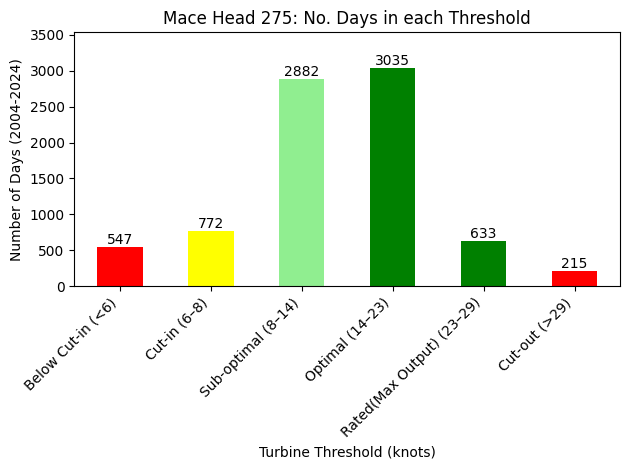

In [38]:
# Define colours for each turbine stage
stage_colours = {
    "Below Cut-in (<6)": "red",
    "Cut-out (>29)": "red",
    "Cut-in (6–8)": "yellow",
    "Sub-optimal (8–14)": "lightgreen",
    "Optimal (14–23)": "green",
    "Rated(Max Output) (23–29)": "green",
}

# Generate colour list in the same order as stage_counts
bar_colours = [stage_colours[stage] for stage in stage_counts.index]


# Plot number of days bar chart 
plt.figure()
stage_counts.plot(kind="bar", color=bar_colours)

# Add call outs for each bar
for i, v in enumerate(stage_counts):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')  

# Generate colour list in the same order as stage_counts
bar_colours = [stage_colours[stage] for stage in stage_counts.index]

# Increase y-axis limit by 500 (Allow space for call outs)
plt.ylim(0, stage_counts.max() + 500)

# Chart details
plt.title("Mace Head 275: No. Days in each Threshold")
plt.xlabel("Turbine Threshold (knots)")
plt.ylabel("Number of Days (2004-2024)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

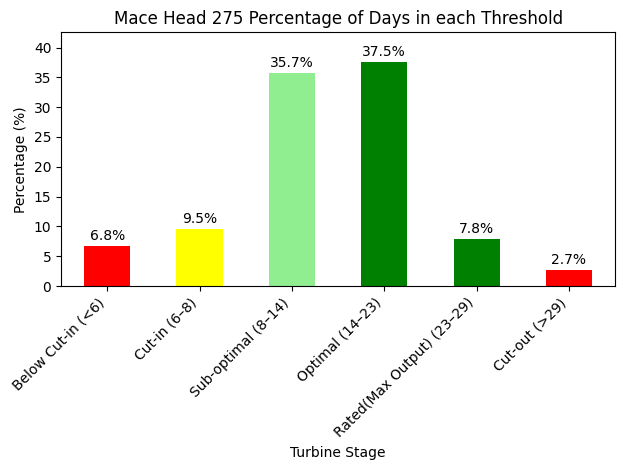

In [39]:
# Define colours for each turbine stage
stage_colours = {
    "Below Cut-in (<6)": "red",
    "Cut-out (>29)": "red",
    "Cut-in (6–8)": "yellow",
    "Sub-optimal (8–14)": "lightgreen",
    "Optimal (14–23)": "green",
    "Rated(Max Output) (23–29)": "green",
}

# Generate colour list in the same order as stage_counts
bar_colours = [stage_colours[stage] for stage in stage_counts.index]

# Calculate percentage of days in each stage
stage_percent = stage_counts / stage_counts.sum() * 100

# Plot percentage bar chart
plt.figure()
stage_percent.plot(kind="bar", color=bar_colours)

# Add call outs at top of bars
for i, v in enumerate(stage_percent):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', va='bottom')

# Increase y-axis limit by 5% (Allow space for call outs)
plt.ylim(0, stage_percent.max() + 5)

# Plot details
plt.title("Mace Head 275 Percentage of Days in each Threshold")
plt.xlabel("Turbine Stage")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [42]:
# Create summary dataframe
Summary275dl = pd.DataFrame({"Count": stage_counts,"Percentage (%)": stage_percent.round(2)})

# show
print(Summary275dl)

                           Count  Percentage (%)
275_Daily_Thresholds                            
Below Cut-in (<6)            547            6.77
Cut-in (6–8)                 772            9.55
Sub-optimal (8–14)          2882           35.65
Optimal (14–23)             3035           37.54
Rated(Max Output) (23–29)    633            7.83
Cut-out (>29)                215            2.66


**Comment** This gives us a nice summary of days to do the following:

- Plug into a simplified energy formula to see how much energy in GWH the a Mace Head windfarm could theoreically have produced in the time period of 2004 to 2024.
- Calulate how many danger days it suffered a Cut Out. 
- Calculate how many days it produced nothing (Below Cut-In + Cut-Out)


#### (4.2) Energy Output for Mace Head 2004 to 2024

**Bad Days - No Energy Produced, Potential Damage to Wind Turbines**

In [40]:
# Calculate number of days with hg > 60 kn from 2004 to 2024
days_hg_above_60 = (
    data_275dl_WindOnly.loc[
        (data_275dl_WindOnly["date"] >= "2004-01-01") &
        (data_275dl_WindOnly["date"] <  "2025-01-01") &
        (data_275dl_WindOnly["hg"] > 60)
    ]
    .shape[0]
)

#Show
print(f"Number of days with hg > 60 (2004–2024): {days_hg_above_60}")


Number of days with hg > 60 (2004–2024): 117


In [48]:
# Create a combined bad days summary Series
# Build combined summary using correct index names
BadDays = pd.Series({
    "Below Cut-in": Summary275dl.loc["Below Cut-in (<6)", "Count"],
    "Cut-out": Summary275dl.loc["Cut-out (>29)", "Count"],
    "HG > 60kts (Potential Damage)": days_hg_above_60
})

# Show combined summary
print(BadDays)


Below Cut-in                     547
Cut-out                          215
HG > 60kts (Potential Damage)    117
dtype: int64


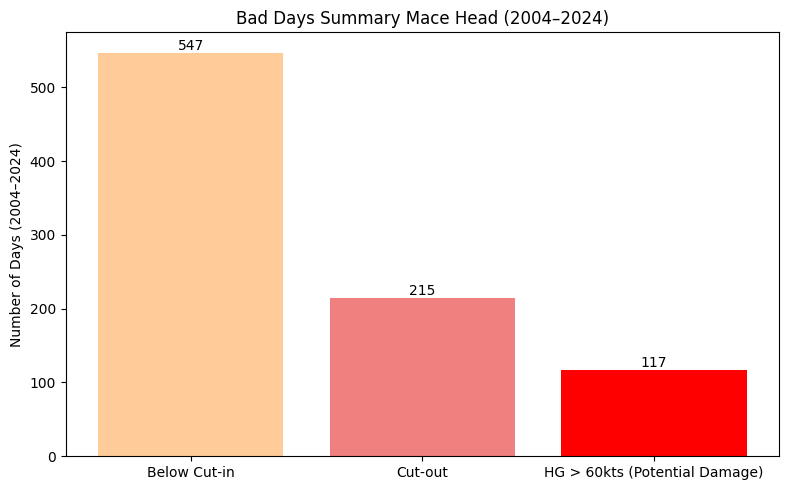

In [81]:
# Plot the combined bad days summary
plt.figure(figsize=(8, 5))

bars = plt.bar(
    BadDays.index,
    BadDays.values,
    color=["#FFCC99", "lightcoral", "red"]
)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom"
    )

# Plot details
plt.ylabel("Number of Days (2004–2024)")
plt.title("Bad Days Summary Mace Head (2004–2024)")
plt.tight_layout()
plt.show()


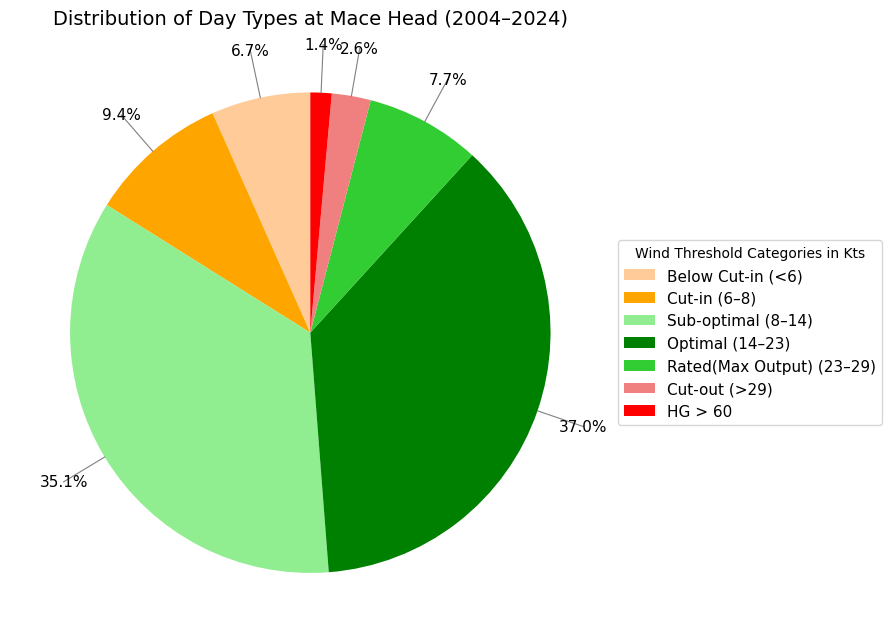

In [75]:
# Pie chart data
pie_data = Summary275dl["Count"].copy()
pie_data.loc["HG > 60"] = days_hg_above_60

colors = [
    "#FFCC99",   # Below Cut-in (got a light orange shade from chatGPT)
    "orange",   # Cut-in
    "lightgreen",   # Sub-optimal
    "green",        # Optimal
    "limegreen",        # Rated
    "lightcoral",   # Cut-out
    "red"        # HG > 60
]

fig, ax = plt.subplots(figsize=(9, 9))

# Draw pie WITHOUT labels or percentages
wedges, _ = ax.pie(
    pie_data.values,
    startangle=90,
    colors=colors
)

# Calculate percentages
total = pie_data.sum()
percentages = pie_data.values / total * 100

# Add external percentage labels with leader lines
for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 + wedge.theta1) / 2
    angle_rad = np.deg2rad(angle)

    # Start of leader line (edge of pie)
    x = np.cos(angle_rad)
    y = np.sin(angle_rad)

    # End of leader line (outside pie)
    label_x = 1.2 * x
    label_y = 1.2 * y

    ax.plot([x, label_x], [y, label_y], color="gray", linewidth=0.8)

    ax.text(
        label_x,
        label_y,
        f"{percentages[i]:.1f}%",
        ha="center",
        va="center",
        fontsize=11
    )

# Legend with category names only
ax.legend(
    wedges,
    pie_data.index,
    title="Wind Threshold Categories in Kts",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=11
)

ax.set_title(
    "Distribution of Day Types at Mace Head (2004–2024)",
    fontsize=14, loc='center'
)

plt.tight_layout()
plt.show()


In [57]:
# Total number of days in the period
total_days = Summary275dl["Count"].sum()

# Build percentage breakdown
loss_percentages = {
    "Below Cut-in - No Energy": Summary275dl.loc["Below Cut-in (<6)", "Count"] / total_days * 100,
    "Cut-out- Too Windy": Summary275dl.loc["Cut-out (>29)", "Count"] / total_days * 100,
    "HG > 60kts (Potential Damage)": days_hg_above_60 / total_days * 100,
}

# Remaining (operational / non-lost) days
loss_percentages["Operational Days"] = 100 - sum(loss_percentages.values())


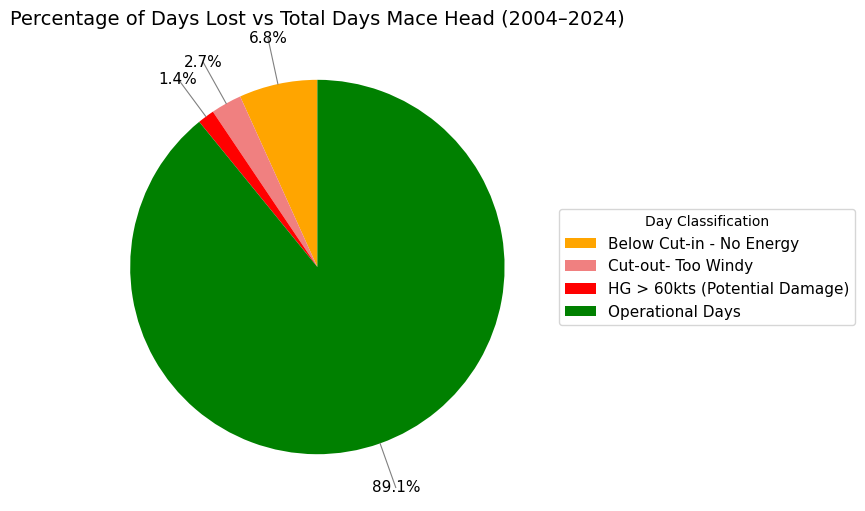

In [79]:
# Pie chart for loss percentages
labels = list(loss_percentages.keys())
sizes = list(loss_percentages.values())

# Define colors
colors = ["Orange", "Lightcoral", "red", "green"]

fig, ax = plt.subplots(figsize=(8, 8))

# Draw pie WITHOUT labels or percentages
wedges, _ = ax.pie(
    sizes,
    startangle=90,
    colors=colors
)

# Convert to percentages
total = sum(sizes)
percentages = [(v / total) * 100 for v in sizes]

# Add external percentage labels with leader lines
for i, wedge in enumerate(wedges):
    angle = (wedge.theta1 + wedge.theta2) / 2
    angle_rad = np.deg2rad(angle)

    # Start of leader line (edge of pie)
    x = np.cos(angle_rad)
    y = np.sin(angle_rad)

    # End of leader line (outside pie)
    label_x = 1.25 * x
    label_y = 1.25 * y

    ax.plot([x, label_x], [y, label_y], color="gray", linewidth=0.8)

    ax.text(
        label_x,
        label_y,
        f"{percentages[i]:.1f}%",
        ha="center",
        va="center",
        fontsize=11
    )

# Legend with category names only
ax.legend(
    wedges,
    labels,
    title="Day Classification",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=11
)

# Plot details
ax.set_title(
    "Percentage of Days Lost vs Total Days Mace Head (2004–2024)",
    fontsize=14
)
plt.tight_layout()
plt.show()


**Comment** Not too bad looking, in the last 20 years a potential windfarm at Mace Head would have been producing some energy 90% of the time. However, site selection would be quite important as there were 117 days where the wind gusts were fast enough to potentially damage turbines. Further analysis on air density would need to be required to assess if the wind gusts had sufficient mass to cause actual damage.

**Calculate the Potential Energy Production at Mace Head**

The fundamental formula for wind turbine power is obtained from the kinetic energy of moving air masses. The basic equation for calculating wind power available in the wind is as follows,

P = ½ × ρ × A × V³

Where:

P = Power (watts)

ρ (rho) = Air density (kg/m³)

A = Rotor swept area (m²)

V = Wind speed (m/s)

The equation illustrates the maximum possible energy that can be derived from the wind, but for wind power as a turbine or wind farm output, you need to factor in turbine efficiency and the Betz limit which no wind turbines can achieve more than 59.3 % of the kinetic energy that the wind contains.

Thus, basis the above, the practical formula for wind turbine power output becomes:

P_turbine = ½ × ρ × A × V³ × Cp

Where Cp is the power coefficient, which shows the turbine's efficiency to convert wind energy to electrical energy.

Above formula is sourced directly from : Source: https://kpenergy.in/blog/calculating-power-output-of-wind-turbines

| Parameter              | Assumptions            | Value             | Notes                                           |
| ---------------------- | --------------------- | ----------------- | ----------------------------------------------- |
| Turbine orientation    | 360° yaw capability   | Always faces wind | Assumes ideal yaw control                       |
| Air density (ρ)        | Constant              | **1.225 kg/m³**   | Standard sea-level air density                  |
| Rotor diameter         | Fixed                 | **100 m**         | Representative of modern utility-scale turbines |
| Rotor swept area (A)   | Derived from diameter | **7,854 m²**      | ( A = \pi r^2 ), where ( r = 50 ) m             |
| Power coefficient (Cₚ) | Betz limit            | **0.593**         | Maximum theoretical wind energy extraction      |


**Note** Remember we are working with daily data so we will need to multiply by 24 to get a full day's output. 

In [84]:
# Filter data for operating wind speeds (6 to 29 knots) - Any other time there is no energy being produced 
data_275dl_WindOnly_operating = (
    data_275dl_WindOnly
    .loc[
        (data_275dl_WindOnly["wdsp"] >= 6) &
        (data_275dl_WindOnly["wdsp"] <= 29)
    ]
    .copy()
)


In [85]:
# Convert wind speed from knots to m/s (knots to m/s = knots * 0.514444)
data_275dl_WindOnly_operating["wdsp_ms"] = data_275dl_WindOnly_operating["wdsp"] * 0.514444

# show
print(data_275dl_WindOnly_operating.head(20))

         date  wdsp    hg 275_Daily_Thresholds    wdsp_ms
0  2003-08-14   6.7  17.0         Cut-in (6–8)   3.446775
1  2003-08-15   6.5  15.0         Cut-in (6–8)   3.343886
3  2003-08-17  16.9  34.0      Optimal (14–23)   8.694104
4  2003-08-18  18.5  28.0      Optimal (14–23)   9.517214
5  2003-08-19  15.1  26.0      Optimal (14–23)   7.768104
6  2003-08-20  13.9  28.0   Sub-optimal (8–14)   7.150772
7  2003-08-21  20.6  34.0      Optimal (14–23)  10.597546
8  2003-08-22   9.9  19.0   Sub-optimal (8–14)   5.092996
9  2003-08-23   7.0  18.0         Cut-in (6–8)   3.601108
10 2003-08-24  12.8  26.0   Sub-optimal (8–14)   6.584883
11 2003-08-25  14.8  28.0      Optimal (14–23)   7.613771
12 2003-08-26  14.4  28.0      Optimal (14–23)   7.407994
13 2003-08-27  12.5  24.0   Sub-optimal (8–14)   6.430550
14 2003-08-28  10.3  21.0   Sub-optimal (8–14)   5.298773
15 2003-08-29   9.9  26.0   Sub-optimal (8–14)   5.092996
16 2003-08-30   9.1  23.0   Sub-optimal (8–14)   4.681440
17 2003-08-31 

In [86]:
# Assumptions
rho = 1.225          # air density (kg/m^3)
A = 7854             # rotor swept area (m^2)
Cp = 0.593           # Betz limit (maximum power coefficient)

# Calculate Power in (W) (Instantaneous Power)
data_275dl_WindOnly_operating["power_W"] = (
    0.5 * rho * A * Cp *
    data_275dl_WindOnly_operating["wdsp_ms"] ** 3
)

# Calculate daily energy production in Wh (power in W * 24 hours)
data_275dl_WindOnly_operating["energy_Wh_day"] = (
    data_275dl_WindOnly_operating["power_W"] * 24
)

# Convert daily energy to Megawatt-hours (MWh)
data_275dl_WindOnly_operating["energy_MWh_day"] = (
    data_275dl_WindOnly_operating["energy_Wh_day"] / 1e6
)

# Show
print(data_275dl_WindOnly_operating[["date", "wdsp_ms", "power_W", "energy_MWh_day"]].head(20)
)

         date    wdsp_ms       power_W  energy_MWh_day
0  2003-08-14   3.446775  1.168128e+05        2.803507
1  2003-08-15   3.343886  1.066611e+05        2.559866
3  2003-08-17   8.694104  1.874676e+06       44.992213
4  2003-08-18   9.517214  2.459128e+06       59.019079
5  2003-08-19   7.768104  1.337201e+06       32.092835
6  2003-08-20   7.150772  1.043063e+06       25.033504
7  2003-08-21  10.597546  3.395218e+06       81.485232
8  2003-08-22   5.092996  3.768527e+05        9.044464
9  2003-08-23   3.601108  1.332171e+05        3.197211
10 2003-08-24   6.584883  8.145090e+05       19.548217
11 2003-08-25   7.613771  1.259074e+06       30.217769
12 2003-08-26   7.407994  1.159721e+06       27.833301
13 2003-08-27   6.430550  7.585707e+05       18.205696
14 2003-08-28   5.298773  4.244022e+05       10.185654
15 2003-08-29   5.092996  3.768527e+05        9.044464
16 2003-08-30   4.681440  2.926781e+05        7.024274
17 2003-08-31   4.527107  2.646757e+05        6.352216
19 2003-09

In [87]:
# Extract year from date for annual calculations
data_275dl_WindOnly_operating["year"] = (data_275dl_WindOnly_operating["date"].dt.year)

# Calculate annual energy production in Megawhatt-hours (MWh)
annual_energy_GWh = (
    data_275dl_WindOnly_operating
    .groupby("year")["energy_MWh_day"]
    .sum()
    .reset_index()
)

# Convert to Gigawatt-hours (GWh)
annual_energy_GWh["energy_GWh"] = (
    annual_energy_GWh["energy_MWh_day"] / 1000
)

# Show annual energy output
annual_energy_GWh = annual_energy_GWh[["year", "energy_GWh"]]

print(annual_energy_GWh)

    year  energy_GWh
0   2003    3.527983
1   2004   14.795760
2   2005   12.336789
3   2006   12.959281
4   2007   12.762803
5   2008   14.470355
6   2009   13.256058
7   2010    9.288479
8   2011   17.262050
9   2012   13.359983
10  2013   14.377886
11  2014   13.752958
12  2015   16.146990
13  2016   13.621191
14  2017   14.095233
15  2018   13.833147
16  2019   15.022739
17  2020   16.417764
18  2021   12.159498
19  2022   15.383459
20  2023   15.121274
21  2024   12.434251
22  2025   12.390826


**Benchmarking the Gwh produciton against industry standards:**

The below table was composed using chat gpt - where it derived these averages from https://www.eia.gov/todayinenergy/detail.php?id=52038&utm_source=chatgpt.com


| Capacity factor | Annual energy (GWh) | Interpretation             |
| --------------- | ------------------- | -------------------------- |
| ~25%            | ~6.6 GWh            | Poor / marginal site       |
| ~30%            | ~7.9 GWh            | Typical onshore average    |
| ~35%            | ~9.2 GWh            | Good onshore site          |
| ~40%            | ~10.5 GWh           | Very good / excellent site |


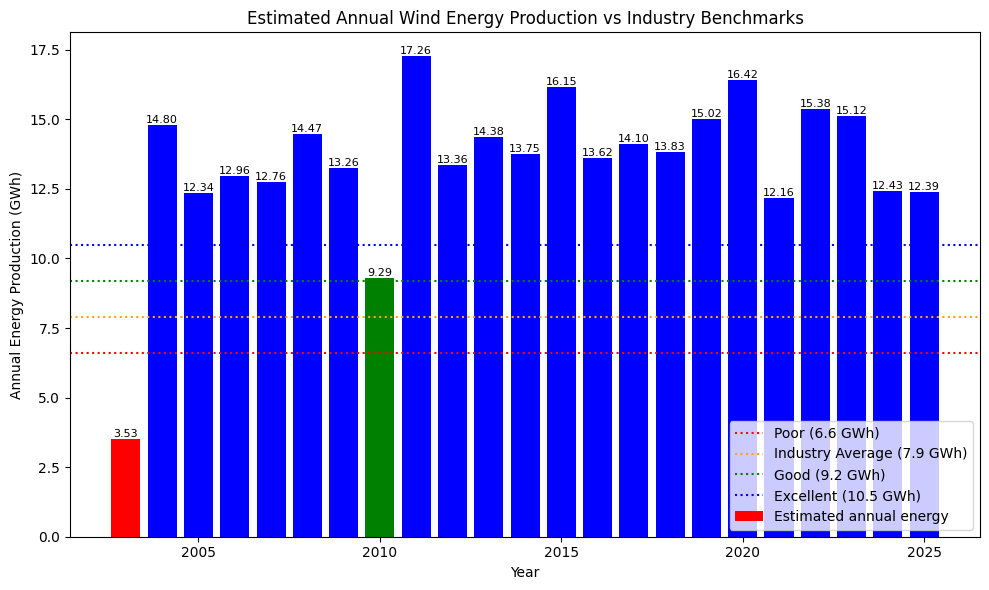

In [92]:
# Industry averages for comparison against 
Poor = 6.6
Ind_Average = 7.9  
Good = 9.2
Excellent = 10.5

# Assign bar colours based on thresholds
bar_colors = []
for value in annual_energy_GWh["energy_GWh"]:
    if value < Poor:
        bar_colors.append("red")
    elif value < Ind_Average:
        bar_colors.append("orange")
    elif value < Good:
        bar_colors.append("lightgreen")
    elif value < Excellent:
        bar_colors.append("green")
    else:
        bar_colors.append("blue")

# Plot annual energy production
plt.figure(figsize=(10, 6))
bars = plt.bar(
    annual_energy_GWh["year"],
    annual_energy_GWh["energy_GWh"],
    color=bar_colors,
    label="Estimated annual energy"
)

# Plot Industry comparison lines
plt.axhline(y=Poor, color="red", linestyle="dotted", label="Poor (6.6 GWh)")
plt.axhline(y=Ind_Average, color="orange", linestyle="dotted", label="Industry Average (7.9 GWh)")
plt.axhline(y=Good, color="green", linestyle="dotted", label="Good (9.2 GWh)")
plt.axhline(y=Excellent, color="blue", linestyle="dotted", label="Excellent (10.5 GWh)")

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=8
    )

# Plot details
plt.xlabel("Year")
plt.ylabel("Annual Energy Production (GWh)")
plt.title("Estimated Annual Wind Energy Production vs Industry Benchmarks")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


**Comment** In general Mace Head looks like a great site well above the excellent threshold for produciton. It did see one year (2004) which was well below the poor threshold, but I suspect this is an issue with the data or weather station at that time as it is such an outlier compared to the other stations. 

**Bit of Fun: Lets see how many pots of tea this energy could have made**

**Comment** Lets assume one kettle boiled (about 0.25 watts) is needed to make one pot of tea - if we convert the gwh produced for Mace Head from 2004 to 2024 to watts and assume how much pots of tea we could have made from all that energy. 

In [94]:
# Calculate total energy produced over the period 2004-2024
total_energy_gwh = annual_energy_GWh['energy_GWh'].sum()
print(f"Total Energy (GWh Mace Head from 2004 -2024): {total_energy_gwh}")

# Convert total_energy_gwh to Wh
total_energy_wh = total_energy_gwh * 1e9  # 1 GWh = 1e9 Wh

# Define Pot of Tea (say one kettle boil is 0.25kwh)
Kettel_Boil = 0.25  

# Calculate number of kettle boils
number_of_pots_tea = total_energy_wh / (Kettel_Boil)
print(f"Number of Pots of Tea Makeable: {number_of_pots_tea:,.0f}")


Total Energy (GWh Mace Head from 2004 -2024): 308.77675597654843
Number of Pots of Tea Makeable: 1,235,107,023,906


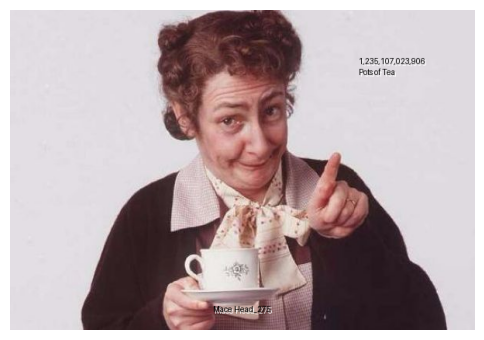

In [122]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Load the image
img = Image.open(r"C:\AlecProjects\PFDA_2025_Project-\ImagesforHumour\Mrs Doyle Tea.jpg")

draw = ImageDraw.Draw(img)

# Main text (top-right)
main_text = f"{number_of_pots_tea:,.0f}\nPots of Tea"

# Bottom title text
bottom_title = "Mace Head_275"

# Fonts
try:
    main_font = ImageFont.truetype("DejaVuSans-Bold.ttf", 800) # cant get the font to change for some reason no matter what size I set it to it stays the same
    title_font = ImageFont.truetype("DejaVuSans-Bold.ttf", 800)
except:
    main_font = ImageFont.load_default()
    title_font = ImageFont.load_default()

# Image size
width, height = img.size

# Position main text (top-right – as you already tuned)
x = int(width * 0.75)
y = int(height * 0.15)

# Draw main text with outline
draw.text((x + 2, y + 2), main_text, font=main_font, fill="white")
draw.text((x, y), main_text, font=main_font, fill="black")

# ---- Bottom-centre title positioning ----
title_bbox = draw.textbbox((0, 0), bottom_title, font=title_font)
title_width = title_bbox[2] - title_bbox[0]

title_x = (width - title_width) // 2
title_y = height - int(height * 0.08)  # a bit above bottom edge

# Draw bottom title with outline
draw.text((title_x + 2, title_y + 2), bottom_title, font=title_font, fill="white")
draw.text((title_x, title_y), bottom_title, font=title_font, fill="black")

# Display
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.show()



---------------

### (3) Comparing All All Stations 

**Disclaimer** To acheive these functions I used my earlier code examples for MACE head and used CHATGPT to make the code into functions.

**Monthly Data Analysis**
- Clean the data - No Nulls, Numeric for Year, WDSP and Gusts 
- Quarterly Perormance Analysis

**Daily Data Analysis**
- Clean the data - No Nulls, Numeric for WDSP, Date Time for Date Time
- Operational Thresholds - Categorise Number of Days into Production Suitability Thresholds
- Define Number of Bad Days
- Site Summary of Production Days 
- Energy Generation - Estimated Annual GWH Production 2004 - 2024
- How many Pots of Tea

#### (3.1) Monthly Data Analysis Functions

---------------

**Function 1:** Clean the Monthly Data 

In [144]:
# Specific imports required for this function
import pandas as pd
import glob
import os

# Function to clean and preview monthly files
def clean_and_preview_monthly_files(folder_path):

    cleaned_data = {}
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

    if not csv_files:
        raise FileNotFoundError("No CSV files found in the specified folder.")

    for file in csv_files:
        print("\n" + "=" * 80)
        print(f"FILE: {os.path.basename(file)}")
        print("=" * 80)

        try:
            df = pd.read_csv(
                file,
                skiprows=19,      # skip row as cols start on row 20
                engine="python"
            )
        except Exception as e:
            print(f"⚠️ Could not read file: {e}")
            continue

        # Ensure required columns exist
        required_cols = ["year", "month", "wdsp", "maxgt"]
        missing = [c for c in required_cols if c not in df.columns]

        if missing:
            print(f"⚠️ Missing required columns: {missing}")
            continue

        # Convert to numeric
        for col in required_cols:
            df[col] = pd.to_numeric(df[col], errors="coerce")

        # Drop rows with nulls
        df_clean = df.dropna(subset=required_cols)

        # Store cleaned data
        station_name = os.path.splitext(os.path.basename(file))[0]
        cleaned_data[station_name] = df_clean

        # Show preview
        print(df_clean.head(10))

    return cleaned_data





In [146]:
#Specify the folder path containing monthly CSV files
folder_path = r"C:\AlecProjects\PFDA_2025_Project-\Monthly All Stations"

#Execute the function
cleaned_monthly_data = clean_and_preview_monthly_files(folder_path)



FILE: mly1275.csv
Empty DataFrame
Columns: [year, month, meant, maxtp, mintp, mnmax, mnmin, rain, gmin, wdsp, maxgt, sun]
Index: []

FILE: mly1975.csv
    year  month meant maxtp mintp mnmax mnmin   rain  gmin  wdsp  maxgt sun
0   2004     10   8.1  15.6  -2.2  11.9   4.3  111.5  -5.4   8.3   37.0    
1   2004     11   7.8  13.2  -0.5  10.6   5.0   67.5  -4.1   7.6   29.0    
2   2004     12   6.1  12.7  -1.8   9.0   3.2   96.8  -4.6   9.6   40.0    
3   2005      1   6.3  13.2  -2.7   9.2   3.3  131.9  -6.7  12.0   61.0    
4   2005      2   4.8  11.7  -3.0   8.0   1.6   25.7  -6.1   8.5   44.0    
5   2005      3   7.6  18.9  -3.0  11.4   3.9   81.3  -8.0   8.4   34.0    
6   2005      4   7.8  16.6  -1.9  12.3   3.4   93.3  -4.3   9.1   42.0    
8   2005      6  14.3  23.4   2.9  18.8   9.8   42.5   0.5   7.3   32.0    
9   2005      7  15.7  28.3   5.2  20.1  11.3   43.9   4.0   7.0   34.0    
10  2005      8  14.8  23.5   6.3  19.3  10.2   76.4   4.6   6.9   34.0    

FILE: mly27

------------------------------

**Function 2:** Divide months into quarters

In [147]:
# specific imports required for this function
import matplotlib.pyplot as plt

# Function to plot quarterly means for 2019-2024
def plot_quarterly_means_2019_2024(
    quarterly_means,
    station_name,
    start_year=2019,
    end_year=2024,
    low_threshold=6,
    high_threshold=60
):
    """
    Plot quarterly mean wind speed and max gusts for a given station.

    Parameters
    ----------
    quarterly_means : pandas.DataFrame
        DataFrame with columns: year, quarter, mean_wdsp, mean_maxgt
    station_name : str
        Name of the station (for plot title)
    start_year : int
        Start year for filtering
    end_year : int
        End year for filtering
    low_threshold : float
        Lower reference threshold
    high_threshold : float
        Upper reference threshold
    """

    # Filter years
    data_filtered = quarterly_means[
        (quarterly_means["year"] >= start_year) &
        (quarterly_means["year"] <= end_year)
    ]

    if data_filtered.empty:
        print(f"⚠️ No data available for {station_name} in {start_year}-{end_year}")
        return

    # Plot
    plt.figure(figsize=(10, 6))

    for column in ["mean_wdsp", "mean_maxgt"]:
        plt.plot(
            data_filtered["year"].astype(str) + " " + data_filtered["quarter"],
            data_filtered[column],
            marker="o",
            label=column
        )

    # Threshold lines
    plt.axhline(
        y=low_threshold,
        color="red",
        linestyle="dotted",
        label=f"Not Optimal Low ({low_threshold})"
    )
    plt.axhline(
        y=high_threshold,
        color="red",
        linestyle="dotted",
        label=f"Not Optimal High ({high_threshold})"
    )

    # Plot details
    plt.title(f"{station_name}: Quarterly Means ({start_year}–{end_year})")
    plt.xlabel("Year and Quarter")
    plt.ylabel("Values")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [152]:
# Specific imports required for this function
import numpy as np

# Function to compute quarterly means from monthly data
def compute_quarterly_means_from_monthly(df):
    """
    Convert cleaned monthly data into quarterly means.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain year, month, wdsp, maxgt

    Returns
    -------
    quarterly_means : pandas.DataFrame
    """

    data = df.copy()

    # Create quarter labels
    data["quarter"] = np.select(
        [
            data["month"].between(1, 3),
            data["month"].between(4, 6),
            data["month"].between(7, 9),
            data["month"].between(10, 12)
        ],
        ["Q1", "Q2", "Q3", "Q4"]
    )

    quarterly_means = (
        data
        .groupby(["year", "quarter"], as_index=False)
        .agg(
            mean_wdsp=("wdsp", "mean"),
            mean_maxgt=("maxgt", "mean")
        )
    )

    return quarterly_means


In [153]:
# Compute quarterly results for all stations
quarterly_results = {}

for station_name, monthly_df in cleaned_monthly_data.items():
    quarterly_results[station_name] = compute_quarterly_means_from_monthly(monthly_df)


⚠️ No data available for mly1275 in 2019-2024


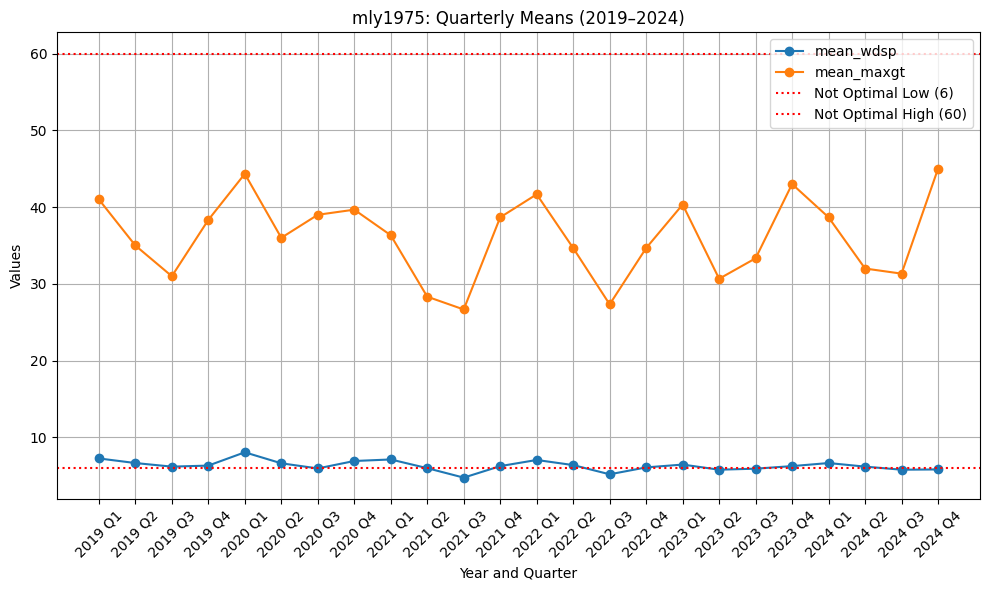

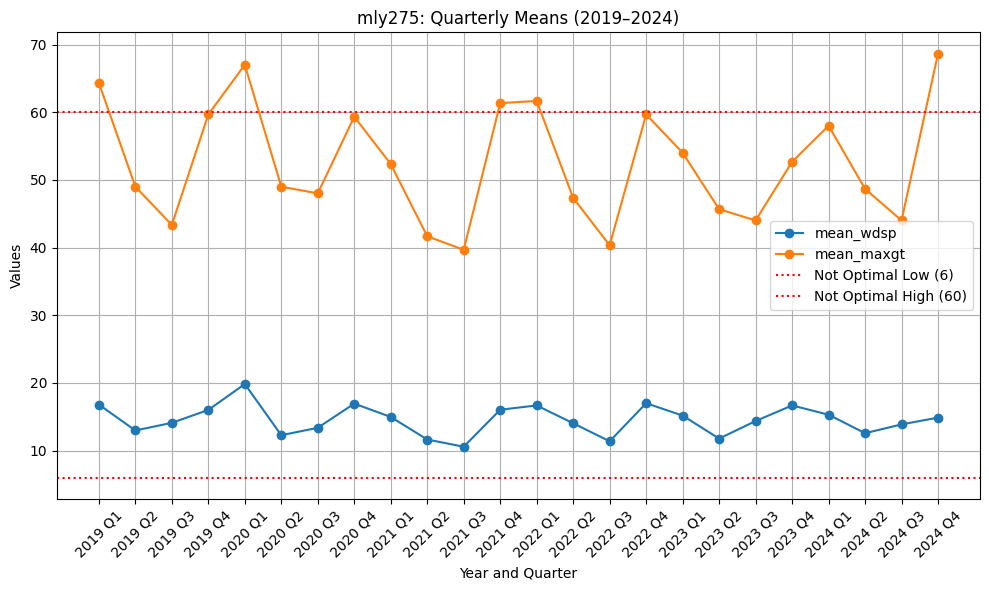

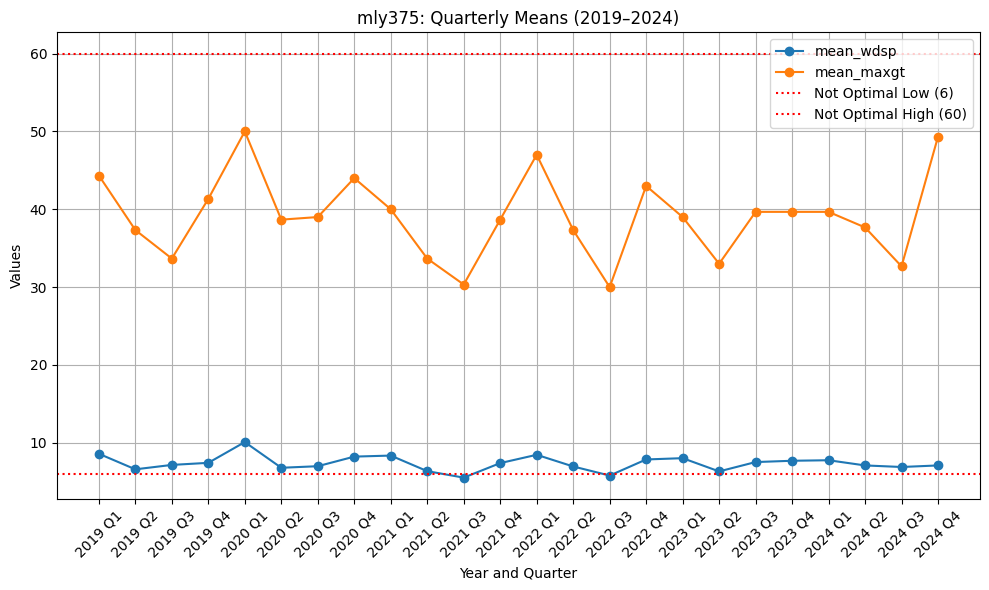

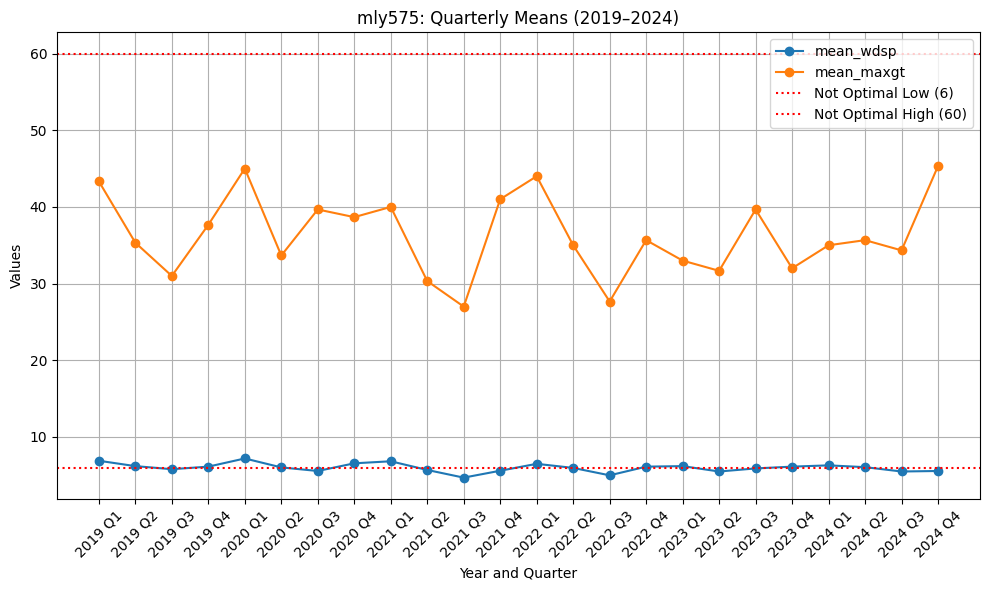

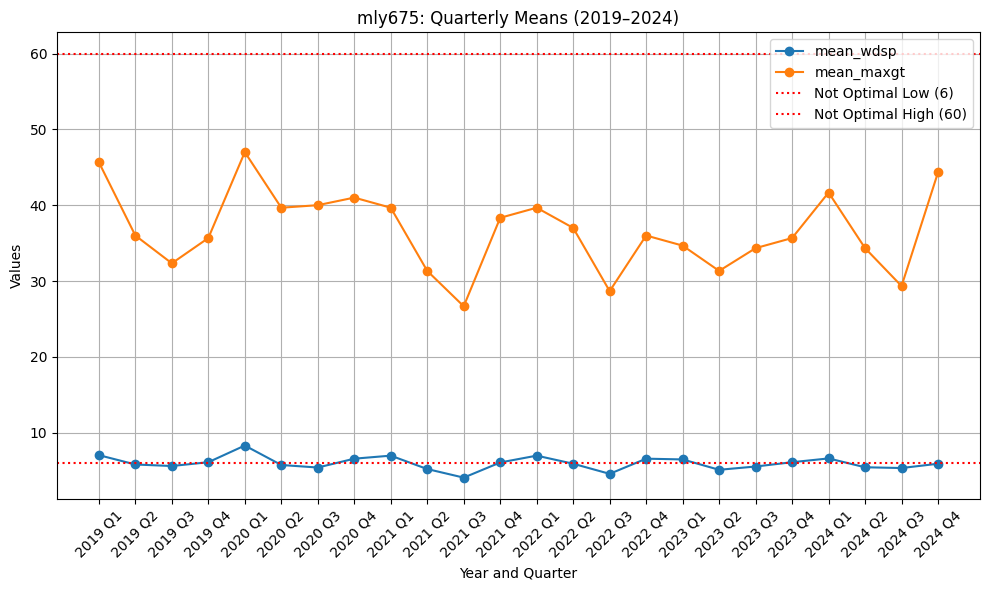

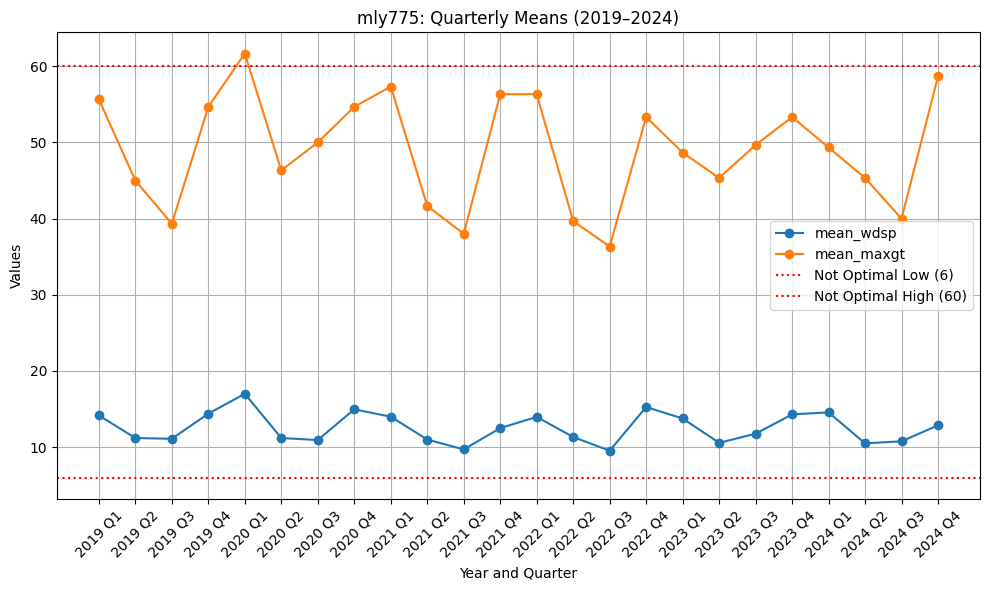

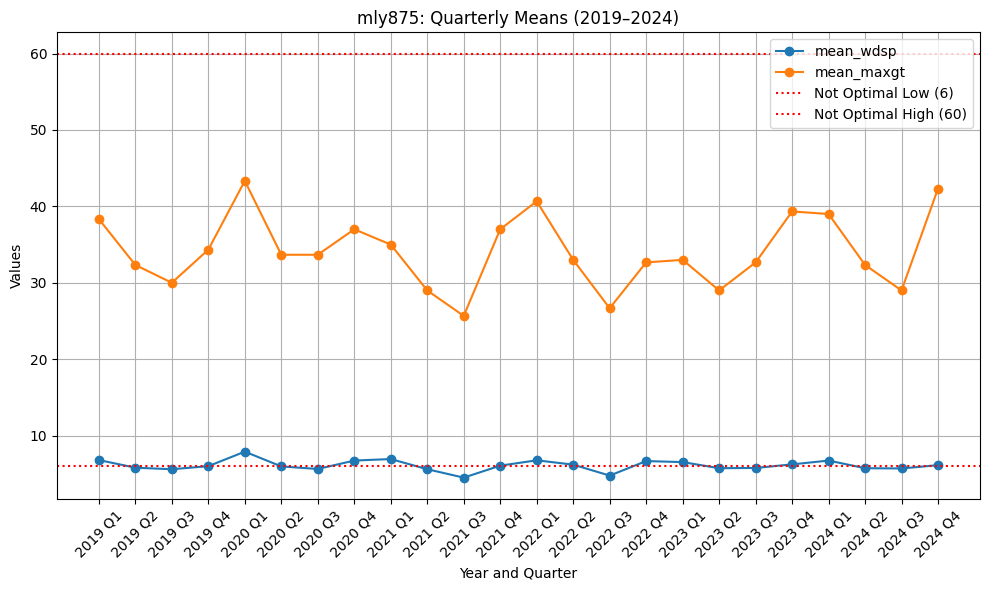

In [155]:
# Execute function to plot quarterly means for all stations
plot_quarterly_means_all_stations(
    quarterly_results,
    start_year=2019,
    end_year=2024
)


**Comment** Bugger, turns out there was no wdsp data available for 1275 Markree I missed that. But at least the other data came out well

------------------

**Function 3:** Most Potential Wind Energy Production Per Year 

In [161]:
# Specific imports required for this function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to plot best and worst quarters
def plot_best_worst_quarters(
    quarterly_means,
    station_name
):
    """
    Identify and plot best and worst wind speed quarters for a station.

    Parameters
    ----------
    quarterly_means : pandas.DataFrame
        Must contain columns: year, quarter, mean_wdsp
    station_name : str
        Station name for plot title

    Returns
    -------
    quarter_performance : pandas.DataFrame
        Summary table of most and least windy quarters
    """

    # Identify least windy quarter per year
    least_quarters = (
        quarterly_means
        .loc[
            quarterly_means.groupby("year")["mean_wdsp"].idxmin()
        ]
        .groupby("quarter")
        .size()
        .reset_index(name="Least")
    )

    # Identify most windy quarter per year
    most_quarters = (
        quarterly_means
        .loc[
            quarterly_means.groupby("year")["mean_wdsp"].idxmax()
        ]
        .groupby("quarter")
        .size()
        .reset_index(name="Most")
    )

    # Merge results
    quarter_performance = (
        most_quarters
        .merge(least_quarters, on="quarter", how="outer")
        .fillna(0)
    )

    # Ensure correct quarter order
    quarter_map = {
    "Q1": "Q1(Jan-Mar)",
    "Q2": "Q2(Apr-Jun)",
    "Q3": "Q3(Jul-Sep)",
    "Q4": "Q4(Oct-Dec)"
}
    quarter_performance["quarter"] = quarter_performance["quarter"].map(quarter_map)



    # Numeric x positions
    x = np.arange(len(quarter_performance))

    # Plot
    plt.figure(figsize=(8, 5))

    plt.bar(
        x,
        quarter_performance["Most"],
        label="Most WDSP of Year",
        color="lightgreen"
    )

    plt.bar(
        x,
        -quarter_performance["Least"],
        label="Least WDSP of Year",
        color="lightcoral"
    )

    plt.axhline(0, color="black", linewidth=0.8)

    # Value labels
    for xi, best, worst in zip(
        x,
        quarter_performance["Most"],
        quarter_performance["Least"]
    ):
        if best > 0:
            plt.text(xi, best, f"{int(best)}", ha="center", va="bottom", fontsize=9)
        if worst > 0:
            plt.text(xi, -worst, f"{int(worst)}", ha="center", va="top", fontsize=9)

    # Axis labels and title
    plt.xticks(x, quarter_performance["quarter"])
    plt.xlabel("Quarter")
    plt.ylabel("Number of Years")
    plt.title(
        f"{station_name}: Times Highest vs Lowest Mean WDSP by Quarter"
    )
    plt.legend()
    plt.tight_layout()
    plt.show()

    return quarter_performance


In [162]:
# Multi-station execution
def plot_best_worst_quarters_all_stations(quarterly_results):
    """
    Run best vs worst quarter analysis for all stations.

    Parameters
    ----------
    quarterly_results : dict
        Dictionary of {station_name: quarterly_means_df}

    Returns
    -------
    results : dict
        Dictionary of quarter_performance DataFrames
    """

    results = {}

    for station_name, quarterly_df in quarterly_results.items():
        results[station_name] = plot_best_worst_quarters(
            quarterly_df,
            station_name=station_name
        )

    return results


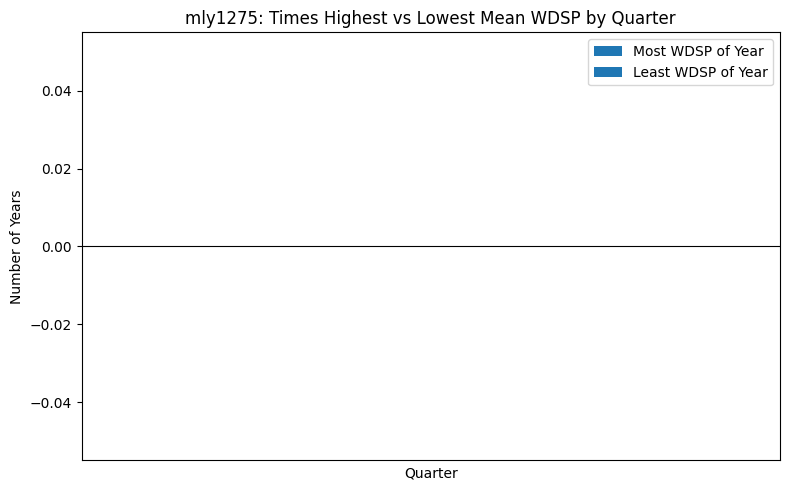

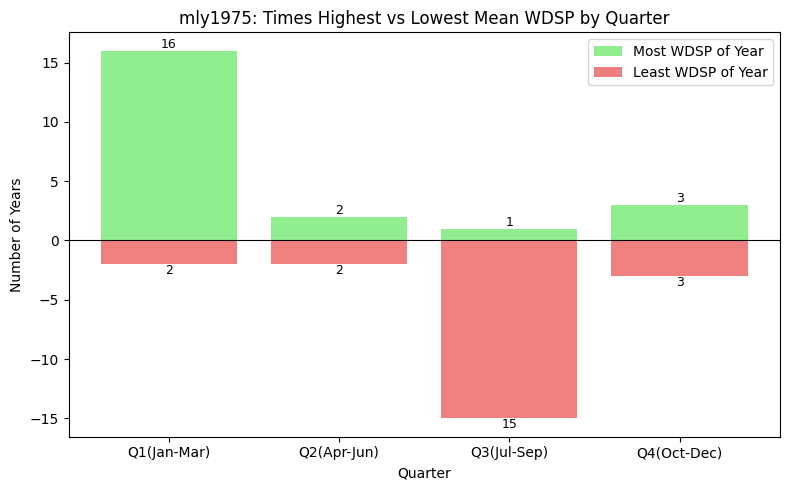

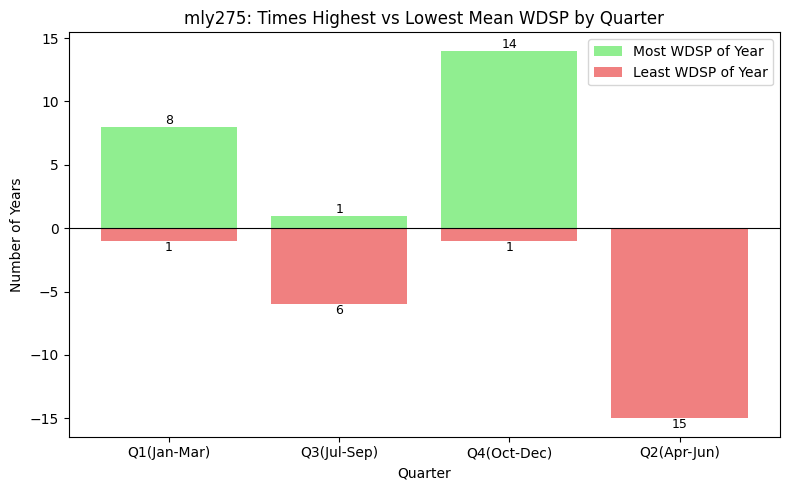

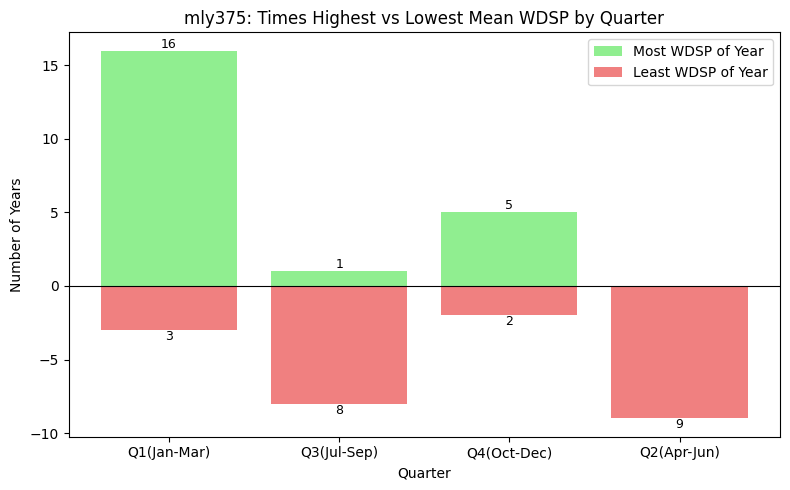

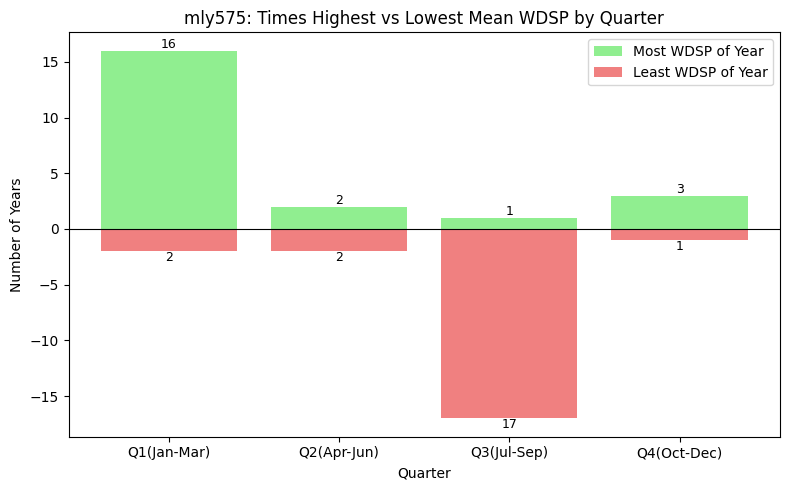

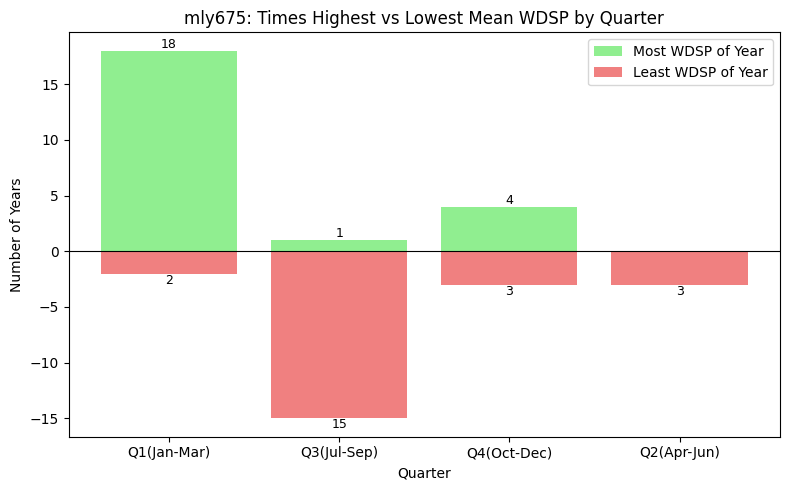

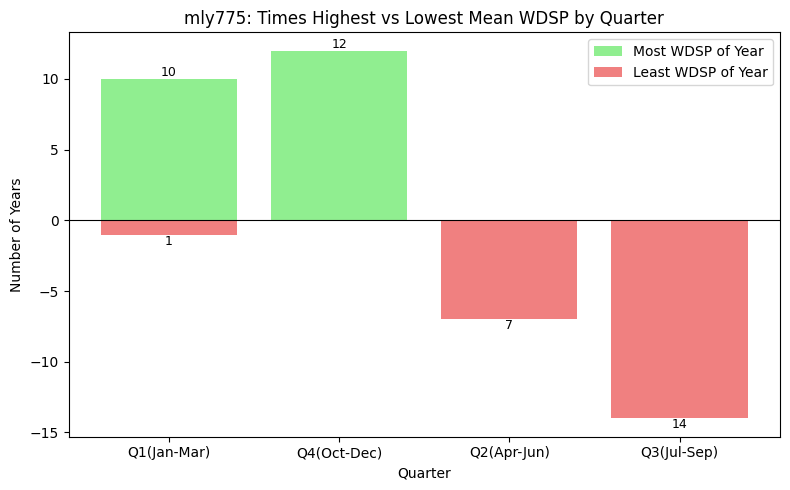

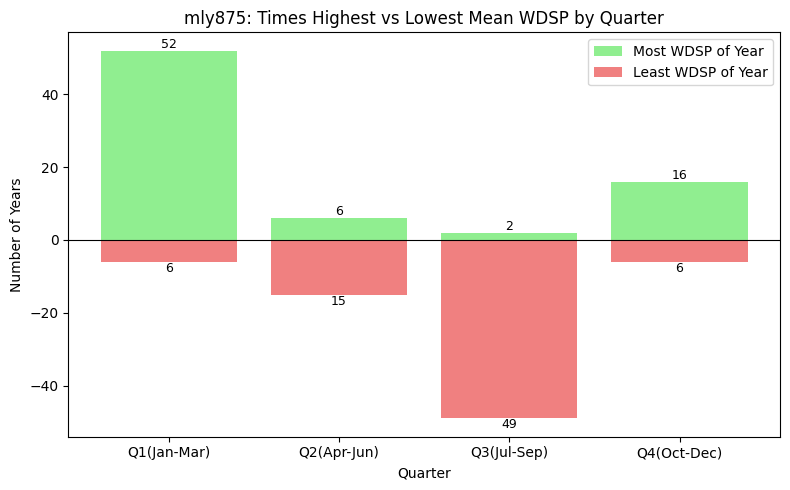

In [163]:
quarter_performance_results = plot_best_worst_quarters_all_stations(
    quarterly_results
)


-----------------------

**Function 4:** Most Potential Downtime

In [164]:
# Specific imports required for this function
import matplotlib.pyplot as plt
import pandas as pd

# Function to plot quarterly gust exceedance
def plot_quarterly_gust_exceedance(
    quarterly_means,
    station_name,
    gust_threshold=60
):
    """
    Analyse and plot quarterly mean max gust exceedances.

    Parameters
    ----------
    quarterly_means : pandas.DataFrame
        Must contain: year, quarter, mean_maxgt
    station_name : str
        Station name for plot title
    gust_threshold : float, optional
        Gust threshold in knots (default = 60)

    Returns
    -------
    quarter_exceed_summary : pandas.DataFrame
        Summary of exceedance frequency per quarter
    """

    data = quarterly_means.copy()

    # Boolean exceedance column
    data["mean_maxgt_exceed"] = data["mean_maxgt"] > gust_threshold

    # Aggregate exceedances by quarter
    quarter_exceed_summary = (
        data
        .groupby("quarter")
        .agg(
            times_exceed=("mean_maxgt_exceed", "sum"),
            total_years=("year", "nunique")
        )
        .reset_index()
    )

    # Ensure correct quarter order
    quarter_order = ["Q1", "Q2", "Q3", "Q4"]
    quarter_exceed_summary["quarter"] = pd.Categorical(
        quarter_exceed_summary["quarter"],
        categories=quarter_order,
        ordered=True
    )
    quarter_exceed_summary = quarter_exceed_summary.sort_values("quarter")

    # Plot
    plt.figure(figsize=(8, 5))
    bars = plt.bar(
        quarter_exceed_summary["quarter"],
        quarter_exceed_summary["times_exceed"],
        color="lightcoral"
    )

    # Add labels
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{int(height)}",
            ha="center",
            va="bottom",
            fontsize=9
        )

    # Plot details
    plt.xlabel("Quarter")
    plt.ylabel("Number of Years")
    plt.title(
        f"{station_name}: Quarterly Mean Max Gust > {gust_threshold} kn"
    )
    plt.tight_layout()
    plt.show()

    return quarter_exceed_summary


In [168]:
def plot_quarterly_gust_exceedance_all_stations(
    quarterly_results,
    gust_threshold=60
):
    """
    Run quarterly gust exceedance analysis for all stations.

    Returns
    -------
    results : dict
        Dictionary of exceedance summary DataFrames
    """

    results = {}

    for station_name, quarterly_df in quarterly_results.items():
        results[station_name] = plot_quarterly_gust_exceedance(
            quarterly_df,
            station_name=station_name,
            gust_threshold=gust_threshold
        )

    return results


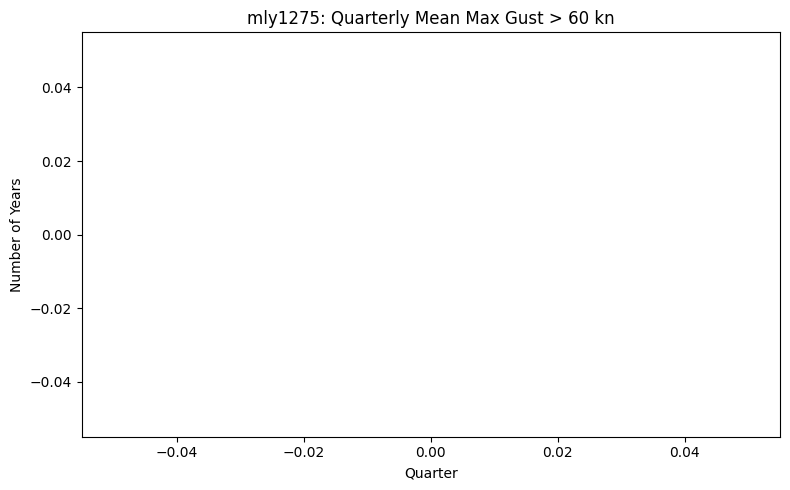

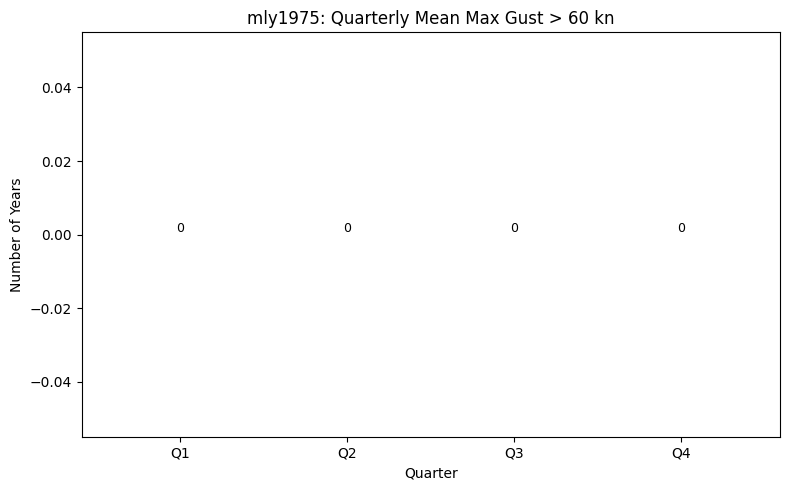

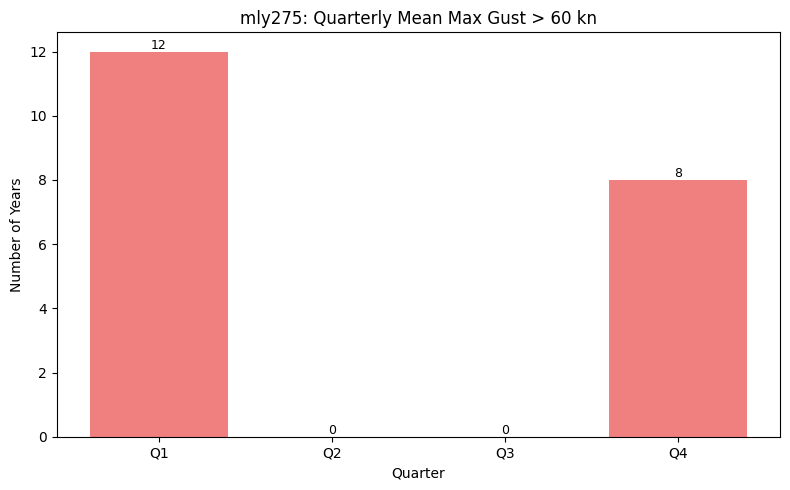

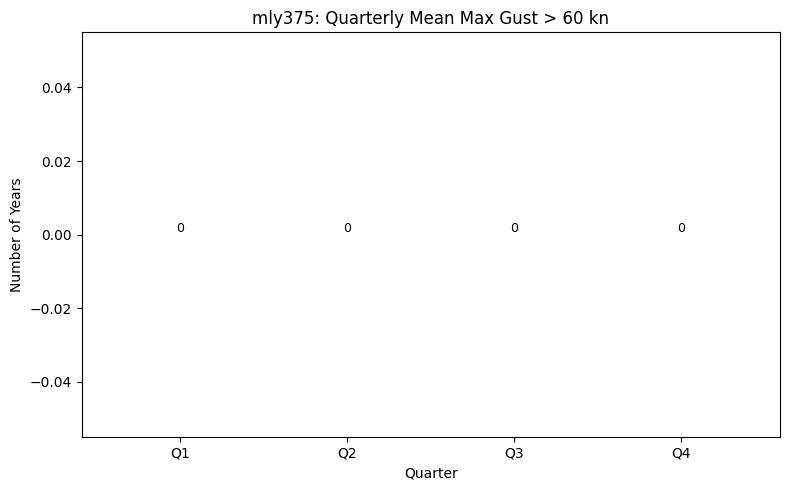

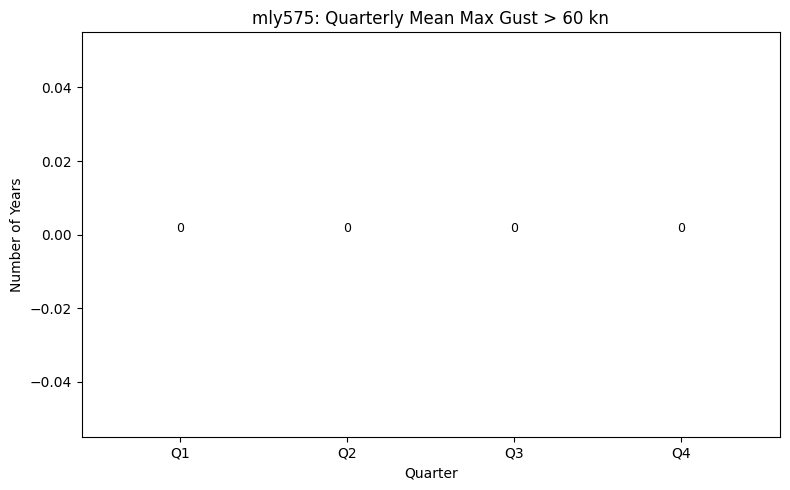

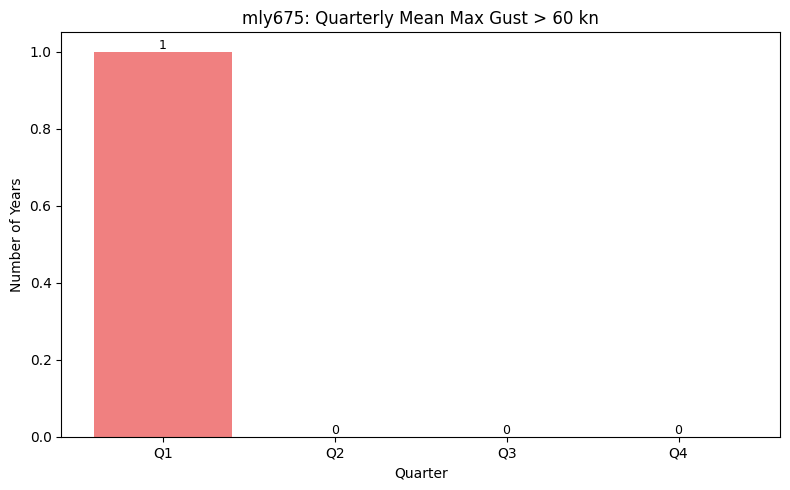

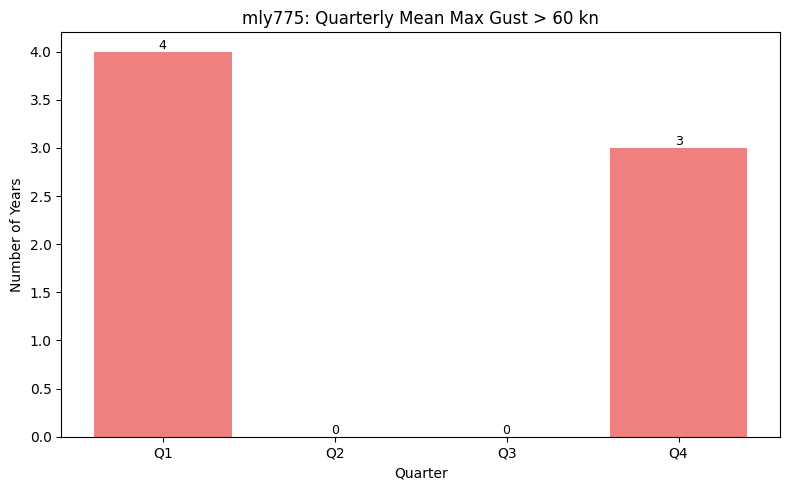

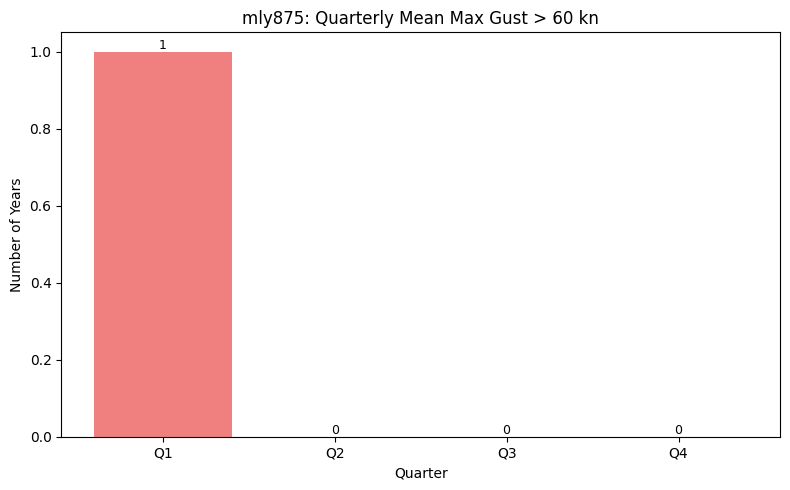

In [169]:
quarterly_gust_exceedance_results = plot_quarterly_gust_exceedance_all_stations(
    quarterly_results,
    gust_threshold=60
)


**Comment** These look kind of messy but really what it is telling us is that a number of sites that never had a max gust exceeding 60 nots (although I am sceptical of that)

-------------------

**Function 5** Clean Daily Data


In [173]:
# Specific imports required for this function
import pandas as pd
import glob
import os

#
def clean_daily_wind_files(folder_path):
    """
    Clean daily wind data files by:
    - Skipping metadata rows
    - Selecting date, wdsp, hg
    - Converting types
    - Dropping nulls
    - Previewing first 10 rows

    Parameters
    ----------
    folder_path : str
        Path to folder containing daily CSV files

    Returns
    -------
    cleaned_daily_data : dict
        Dictionary of cleaned DataFrames keyed by filename
    """

    cleaned_daily_data = {}
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

    if not csv_files:
        raise FileNotFoundError("No CSV files found in the specified folder.")

    for file in csv_files:
        print("\n" + "=" * 80)
        print(f"FILE: {os.path.basename(file)}")
        print("=" * 80)

        try:
            # Read file, skipping metadata rows
            df = pd.read_csv(
                file,
                skiprows=24,
                engine="python"
            )
        except Exception as e:
            print(f"⚠️ Could not read file: {e}")
            continue

        # Normalise column names
        df.columns = df.columns.str.strip().str.lower()

        # Required columns
        required_cols = ["date", "wdsp", "hg"]
        missing = [c for c in required_cols if c not in df.columns]

        if missing:
            print(f"⚠️ Missing required columns: {missing}")
            print("Available columns:", list(df.columns))
            continue

        # Clean and convert
        df_clean = (
            df
            .assign(
                date=lambda d: pd.to_datetime(d["date"], errors="coerce"),
                wdsp=lambda d: pd.to_numeric(d["wdsp"], errors="coerce"),
                hg=lambda d: pd.to_numeric(d["hg"], errors="coerce")
            )[required_cols]
            .dropna(subset=required_cols)
        )

        # Store cleaned data
        station_name = os.path.splitext(os.path.basename(file))[0]
        cleaned_daily_data[station_name] = df_clean

        # Preview
        print(df_clean.head(10))

    return cleaned_daily_data


In [174]:
#execute the function
folder_path = r"C:\AlecProjects\PFDA_2025_Project-\Daily All Stations"

cleaned_daily_data = clean_daily_wind_files(folder_path)



FILE: dly1275.csv
⚠️ Missing required columns: ['date', 'wdsp', 'hg']
Available columns: ['16-may-2005', '0', '13.1', '0.1', '5.6', '0.2', '7.7', '0.3', '0.0', '1017.7', '12.170']

FILE: dly1975.csv


C:\Users\Alec\AppData\Local\Temp\ipykernel_18380\1029920028.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date=lambda d: pd.to_datetime(d["date"], errors="coerce"),


        date  wdsp  hg
0 2004-09-08   6.7  22
1 2004-09-09   6.4  19
2 2004-09-10   6.3  28
3 2004-09-11  14.3  29
4 2004-09-12  13.2  31
5 2004-09-13  14.6  43
6 2004-09-14  14.3  37
7 2004-09-15   6.9  21
8 2004-09-16  13.0  34
9 2004-09-17  12.4  30

FILE: dly275.csv


C:\Users\Alec\AppData\Local\Temp\ipykernel_18380\1029920028.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date=lambda d: pd.to_datetime(d["date"], errors="coerce"),


        date  wdsp    hg
0 2003-08-14   6.7  17.0
1 2003-08-15   6.5  15.0
2 2003-08-16   5.7  13.0
3 2003-08-17  16.9  34.0
4 2003-08-18  18.5  28.0
5 2003-08-19  15.1  26.0
6 2003-08-20  13.9  28.0
7 2003-08-21  20.6  34.0
8 2003-08-22   9.9  19.0
9 2003-08-23   7.0  18.0

FILE: dly375.csv


C:\Users\Alec\AppData\Local\Temp\ipykernel_18380\1029920028.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date=lambda d: pd.to_datetime(d["date"], errors="coerce"),


         date  wdsp  hg
1  2003-08-14   4.3  14
2  2003-08-15   3.3  15
3  2003-08-16   3.4  16
4  2003-08-17   6.4  21
5  2003-08-18   6.8  22
6  2003-08-19   7.5  19
7  2003-08-20   4.9  15
8  2003-08-21   9.9  26
9  2003-08-22   7.3  20
10 2003-08-23   4.0  13

FILE: dly575.csv


C:\Users\Alec\AppData\Local\Temp\ipykernel_18380\1029920028.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date=lambda d: pd.to_datetime(d["date"], errors="coerce"),


        date  wdsp  hg
0 2003-08-11   4.6  12
1 2003-08-12   3.5  14
2 2003-08-13   3.5  14
3 2003-08-14   3.5  15
4 2003-08-15   2.4  10
5 2003-08-16   2.7  10
6 2003-08-17   4.5  17
7 2003-08-18   4.8  19
8 2003-08-19   4.5  17
9 2003-08-20   3.5  17

FILE: dly675.csv


C:\Users\Alec\AppData\Local\Temp\ipykernel_18380\1029920028.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date=lambda d: pd.to_datetime(d["date"], errors="coerce"),


        date  wdsp  hg
0 2003-10-08  11.3  35
1 2003-10-09  10.7  30
2 2003-10-10   6.2  20
3 2003-10-11   3.0  11
4 2003-10-12   6.8  20
5 2003-10-13   5.4  14
6 2003-10-14   5.4  15
7 2003-10-15   5.6  19
8 2003-10-16   5.9  20
9 2003-10-17   6.0  21

FILE: dly775.csv


C:\Users\Alec\AppData\Local\Temp\ipykernel_18380\1029920028.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date=lambda d: pd.to_datetime(d["date"], errors="coerce"),


        date  wdsp  hg
0 2004-05-01   9.1  21
1 2004-05-02   5.8  14
2 2004-05-03  15.0  39
3 2004-05-04  27.8  57
4 2004-05-05  17.4  36
5 2004-05-06  14.1  30
6 2004-05-07  11.4  22
7 2004-05-08   6.0  13
8 2004-05-09   6.1  19
9 2004-05-10   5.1  13

FILE: dly875.csv


C:\Users\Alec\AppData\Local\Temp\ipykernel_18380\1029920028.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date=lambda d: pd.to_datetime(d["date"], errors="coerce"),


        date  wdsp    hg
0 1973-11-08  17.6  37.0
1 1973-11-09  14.8  36.0
2 1973-11-10  10.4  36.0
3 1973-11-11   9.3  29.0
4 1973-11-12  20.0  45.0
5 1973-11-13  14.1  32.0
6 1973-11-14   9.0  33.0
7 1973-11-15   9.0  22.0
8 1973-11-16   6.0  23.0
9 1973-11-17   6.5  30.0


--------------

**Function 6** Define thresholds for production and categorise daily data 

In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_daily_turbine_thresholds(
    daily_df,
    station_name,
    start_date="2004-01-01",
    end_date="2025-01-01"
):
    """
    Analyse and plot daily wind speed turbine thresholds:
    - Number of days in each threshold
    - Percentage of days in each threshold

    Parameters
    ----------
    daily_df : pandas.DataFrame
        Cleaned daily data with columns: date, wdsp
    station_name : str
        Station name for plot titles
    start_date : str
        Start date for filtering (inclusive)
    end_date : str
        End date for filtering (exclusive)

    Returns
    -------
    stage_counts : pandas.Series
        Number of days in each turbine threshold
    stage_percent : pandas.Series
        Percentage of days in each turbine threshold
    """

    # Define turbine thresholds
    bins = [0, 6, 8, 14, 23, 29, np.inf]
    labels = [
        "Below Cut-in (<6)",
        "Cut-in (6–8)",
        "Sub-optimal (8–14)",
        "Optimal (14–23)",
        "Rated(Max Output) (23–29)",
        "Cut-out (>29)"
    ]

    # Filter date range
    data = daily_df.loc[
        (daily_df["date"] >= start_date) &
        (daily_df["date"] < end_date)
    ].copy()

    # Assign turbine stages
    data["turbine_stage"] = pd.cut(
        data["wdsp"],
        bins=bins,
        labels=labels,
        right=False
    )

    # Count days per stage
    stage_counts = data["turbine_stage"].value_counts().sort_index()

    # Calculate percentages
    stage_percent = stage_counts / stage_counts.sum() * 100

    print("\nDaily threshold counts:")
    print(stage_counts)

    # Define colours for each stage
    stage_colours = {
        "Below Cut-in (<6)": "red",
        "Cut-out (>29)": "red",
        "Cut-in (6–8)": "yellow",
        "Sub-optimal (8–14)": "lightgreen",
        "Optimal (14–23)": "green",
        "Rated(Max Output) (23–29)": "green",
    }

    bar_colours = [stage_colours[stage] for stage in stage_counts.index]

    # =========================
    # Plot 1: Number of days
    # =========================
    plt.figure(figsize=(8, 5))
    bars = plt.bar(
        stage_counts.index,
        stage_counts.values,
        color=bar_colours
    )

    for i, v in enumerate(stage_counts.values):
        plt.text(i, v + 0.5, str(int(v)), ha="center", va="bottom", fontsize=9)

    plt.ylim(0, stage_counts.max() + 500)
    plt.title(f"{station_name}: No. Days in Each Turbine Threshold")
    plt.xlabel("Turbine Threshold (knots)")
    plt.ylabel("Number of Days (2004–2024)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # =========================
    # Plot 2: Percentage of days
    # =========================
    plt.figure(figsize=(8, 5))
    bars = plt.bar(
        stage_percent.index,
        stage_percent.values,
        color=bar_colours
    )

    for i, v in enumerate(stage_percent.values):
        plt.text(i, v + 0.5, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)

    plt.ylim(0, stage_percent.max() + 5)
    plt.title(f"{station_name}: Percentage of Days in Each Threshold")
    plt.xlabel("Turbine Stage")
    plt.ylabel("Percentage (%)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    return stage_counts, stage_percent


In [180]:
def plot_daily_turbine_thresholds_all_stations(cleaned_daily_data):
    """
    Run daily turbine threshold analysis for all stations.

    Returns
    -------
    results : dict
        Dictionary of stage_counts per station
    """

    results = {}

    for station_name, daily_df in cleaned_daily_data.items():
        results[station_name] = plot_daily_turbine_thresholds(
            daily_df,
            station_name=station_name
        )

    return results



Daily threshold counts:
turbine_stage
Below Cut-in (<6)            2986
Cut-in (6–8)                 1936
Sub-optimal (8–14)           2274
Optimal (14–23)               203
Rated(Max Output) (23–29)       0
Cut-out (>29)                   1
Name: count, dtype: int64


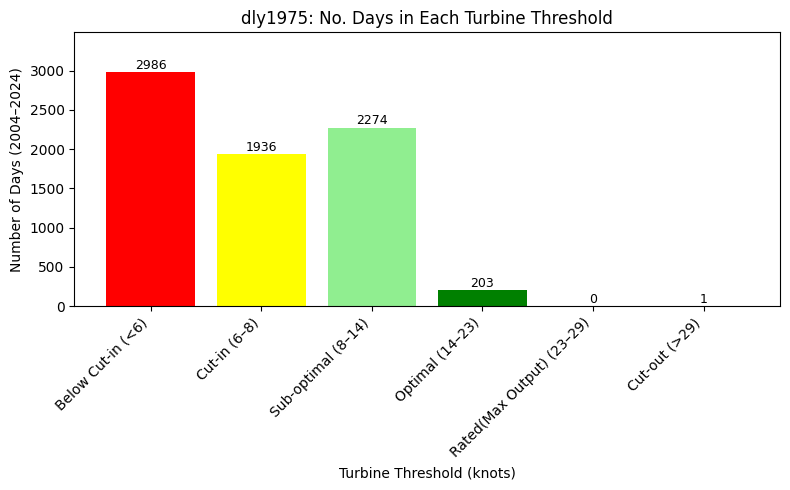

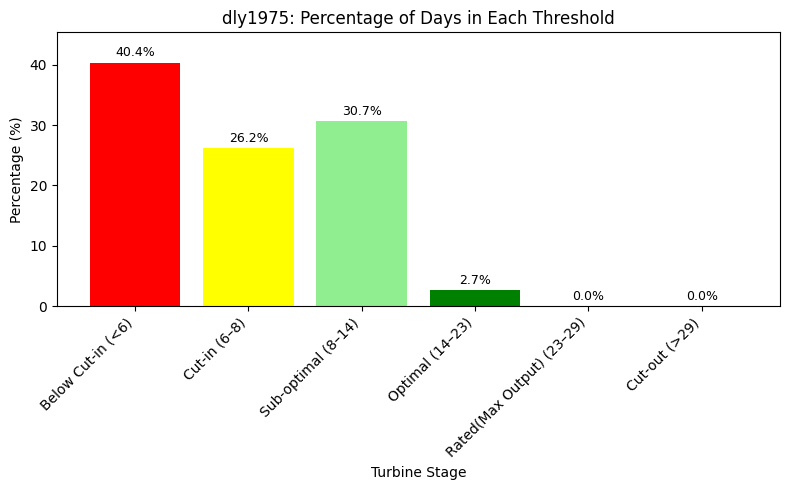


Daily threshold counts:
turbine_stage
Below Cut-in (<6)             524
Cut-in (6–8)                  734
Sub-optimal (8–14)           2706
Optimal (14–23)              2874
Rated(Max Output) (23–29)     603
Cut-out (>29)                 207
Name: count, dtype: int64


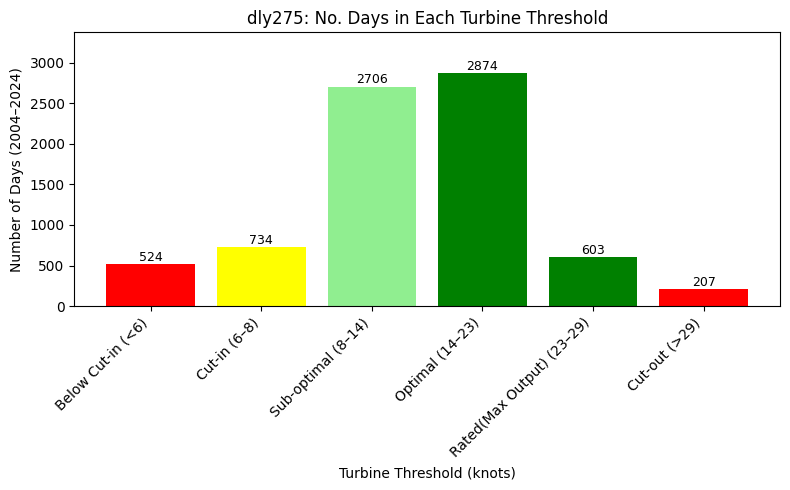

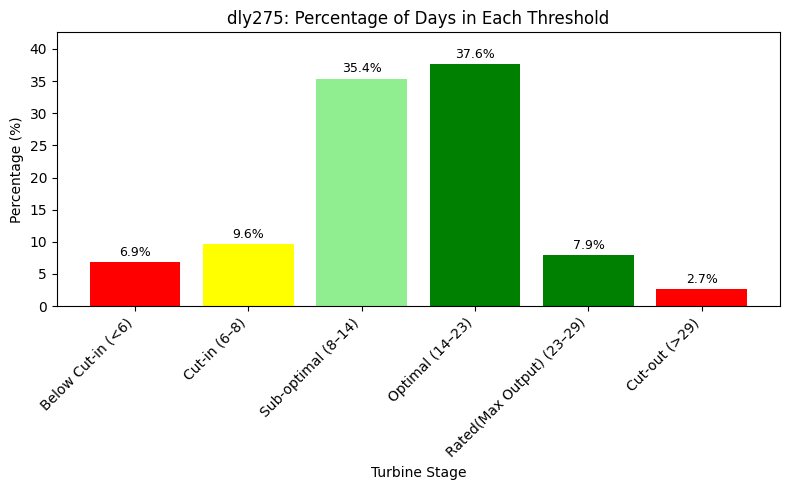


Daily threshold counts:
turbine_stage
Below Cut-in (<6)            3015
Cut-in (6–8)                 1706
Sub-optimal (8–14)           2510
Optimal (14–23)               393
Rated(Max Output) (23–29)       1
Cut-out (>29)                   0
Name: count, dtype: int64


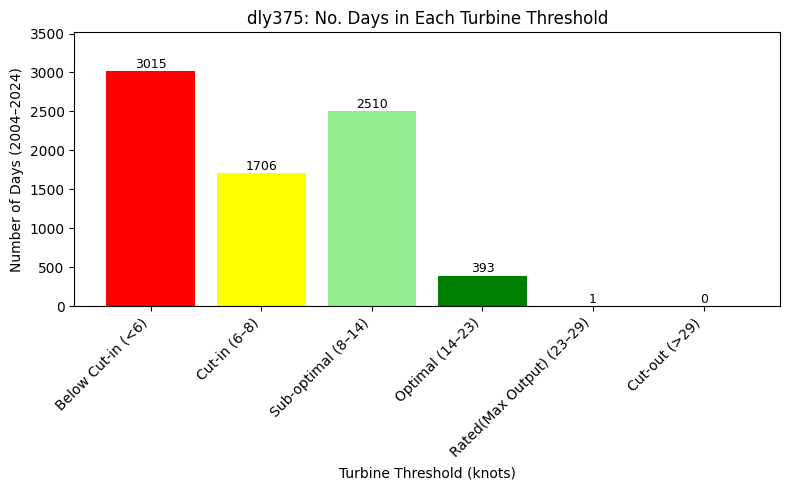

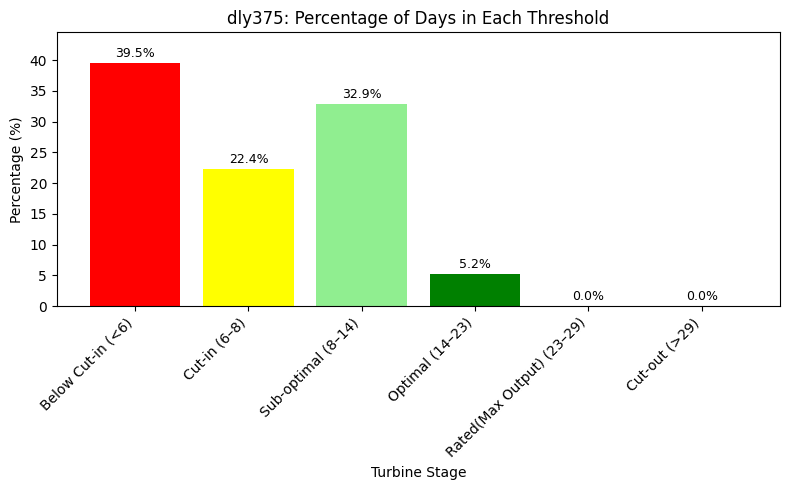


Daily threshold counts:
turbine_stage
Below Cut-in (<6)            4364
Cut-in (6–8)                 1815
Sub-optimal (8–14)           1383
Optimal (14–23)                72
Rated(Max Output) (23–29)       0
Cut-out (>29)                   0
Name: count, dtype: int64


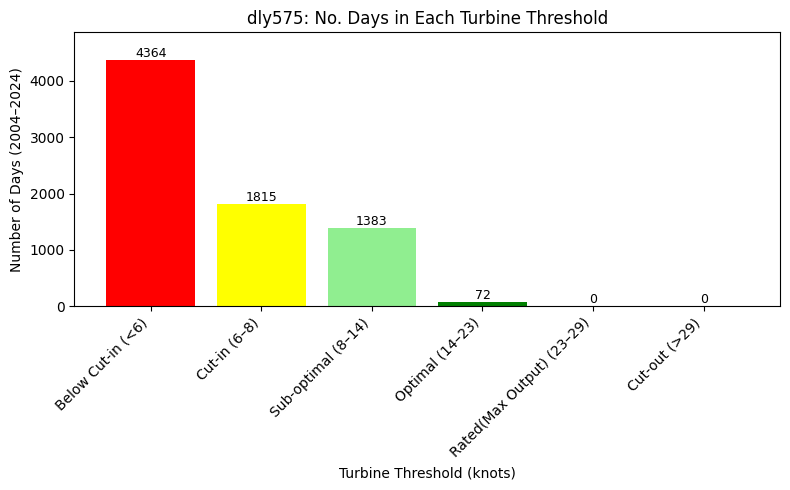

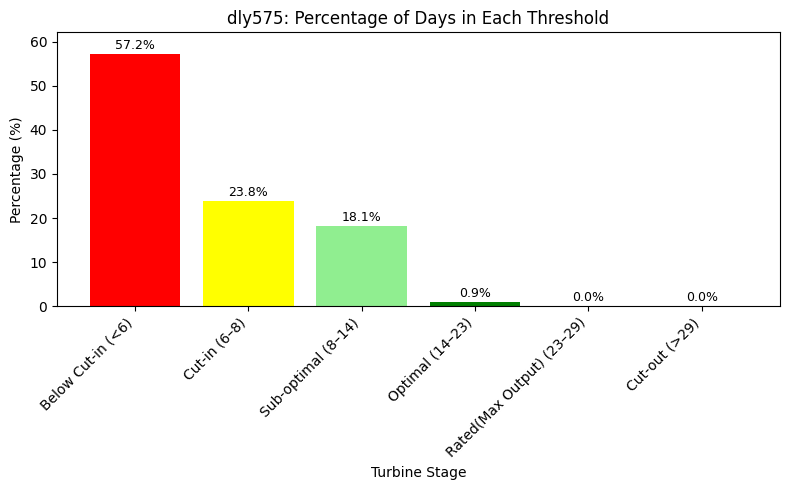


Daily threshold counts:
turbine_stage
Below Cut-in (<6)            3850
Cut-in (6–8)                 1729
Sub-optimal (8–14)           1963
Optimal (14–23)               104
Rated(Max Output) (23–29)       0
Cut-out (>29)                   0
Name: count, dtype: int64


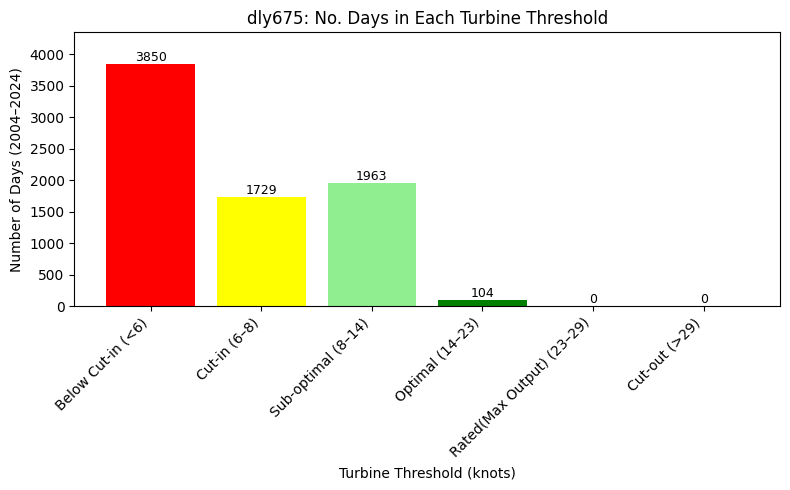

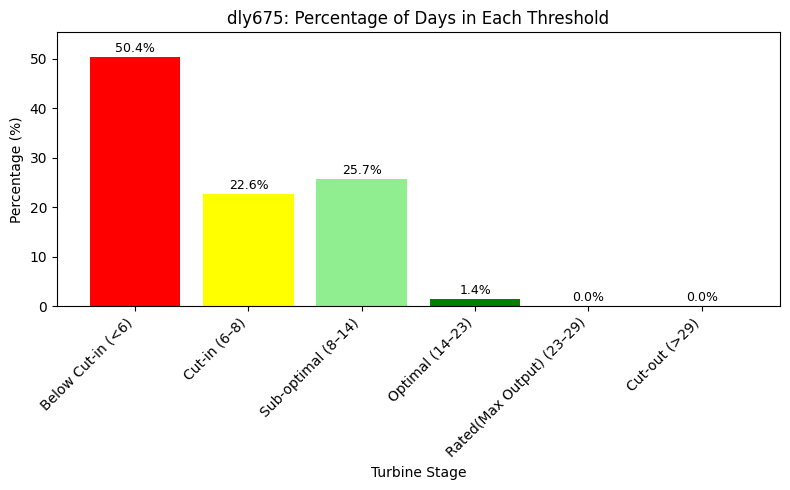


Daily threshold counts:
turbine_stage
Below Cut-in (<6)             776
Cut-in (6–8)                 1037
Sub-optimal (8–14)           3152
Optimal (14–23)              2220
Rated(Max Output) (23–29)     293
Cut-out (>29)                  53
Name: count, dtype: int64


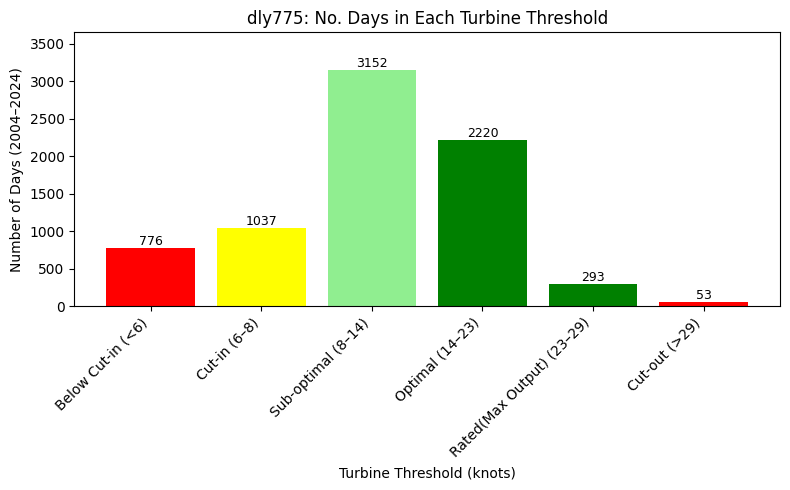

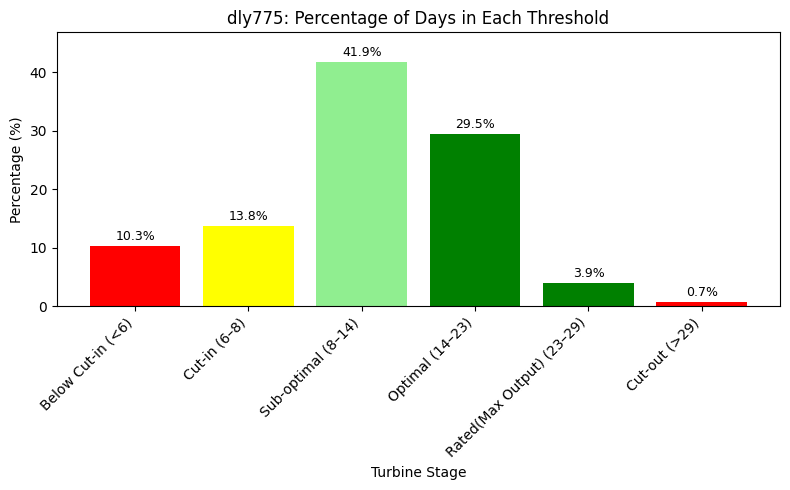


Daily threshold counts:
turbine_stage
Below Cut-in (<6)            4016
Cut-in (6–8)                 1837
Sub-optimal (8–14)           1746
Optimal (14–23)                71
Rated(Max Output) (23–29)       0
Cut-out (>29)                   0
Name: count, dtype: int64


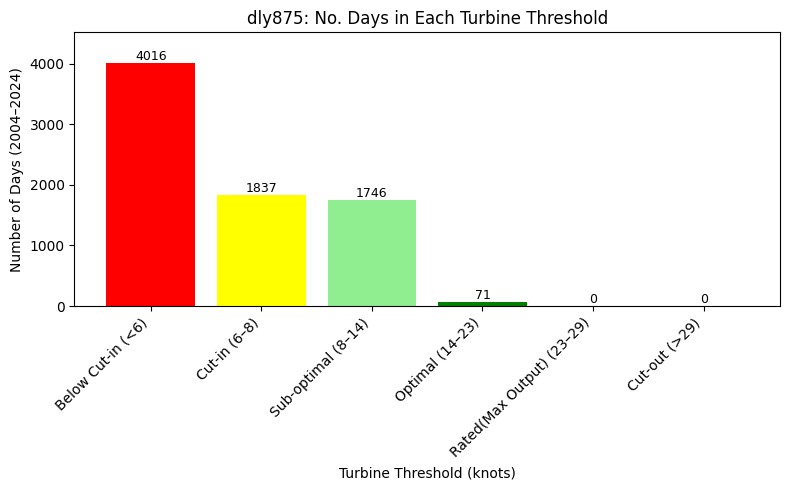

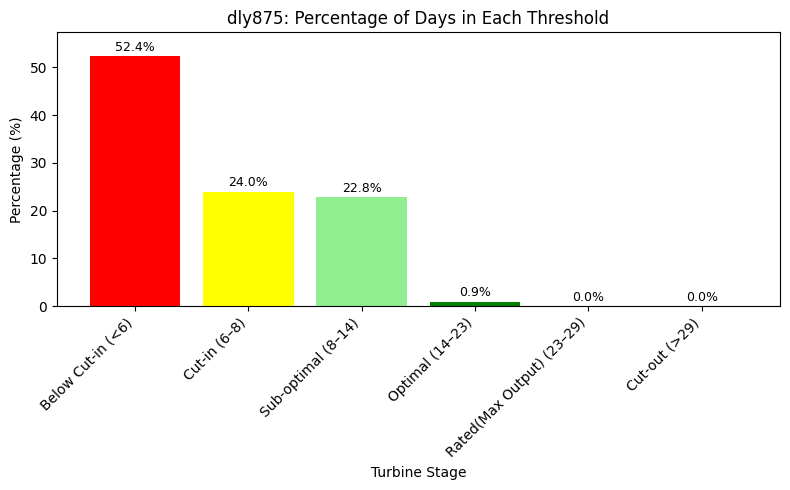

In [181]:
daily_threshold_results = plot_daily_turbine_thresholds_all_stations(
    cleaned_daily_data
)


-----------

**Function 7** Bad days - No Energy Produced, Potential Damage

In [183]:
# Specific imports required for this function
import pandas as pd
import matplotlib.pyplot as plt

# Function to plot bad days summary
def plot_bad_days_summary(
    daily_df,
    stage_counts,
    station_name,
    start_date="2004-01-01",
    end_date="2025-01-01",
    gust_threshold=60
):
    """
    Analyse and plot 'bad days' based on:
    - Below cut-in wind speeds
    - Cut-out wind speeds
    - Extreme gusts (hg > threshold)

    Parameters
    ----------
    daily_df : pandas.DataFrame
        Cleaned daily data with columns: date, hg
    stage_counts : pandas.Series
        Output from turbine threshold analysis (counts)
    station_name : str
        Station name for plot title
    start_date : str
        Start date for filtering
    end_date : str
        End date for filtering
    gust_threshold : float
        Gust threshold in knots (default = 60)

    Returns
    -------
    bad_days : pandas.Series
        Summary of bad days by category
    """

    # Count extreme gust days
    days_hg_above = (
        daily_df.loc[
            (daily_df["date"] >= start_date) &
            (daily_df["date"] < end_date) &
            (daily_df["hg"] > gust_threshold)
        ]
        .shape[0]
    )

    print(f"\n{station_name}: Days with hg > {gust_threshold} kn = {days_hg_above}")

    # Build combined bad-days summary
    bad_days = pd.Series({
        "Below Cut-in": stage_counts.get("Below Cut-in (<6)", 0),
        "Cut-out": stage_counts.get("Cut-out (>29)", 0),
        f"HG > {gust_threshold}kts (Potential Damage)": days_hg_above
    })

    print("Bad Days Summary:")
    print(bad_days)

    # Plot
    plt.figure(figsize=(8, 5))
    bars = plt.bar(
        bad_days.index,
        bad_days.values,
        color=["#FFCC99", "lightcoral", "red"]
    )

    # Add labels
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{int(height)}",
            ha="center",
            va="bottom"
        )

    plt.ylabel("Number of Days (2004–2024)")
    plt.title(f"Bad Days Summary – {station_name} (2004–2024)")
    plt.tight_layout()
    plt.show()

    return bad_days

In [ ]:
# Multi-station execution
def plot_bad_days_all_stations(
    cleaned_daily_data,
    daily_threshold_results,
    gust_threshold=60
):
    """
    Run bad-days analysis for all stations.

    Returns
    -------
    results : dict
        Dictionary of bad-days summaries per station
    """

    results = {}

    for station_name, daily_df in cleaned_daily_data.items():
        stage_counts = daily_threshold_results[station_name][0]

        results[station_name] = plot_bad_days_summary(
            daily_df=daily_df,
            stage_counts=stage_counts,
            station_name=station_name,
            gust_threshold=gust_threshold
        )

    return results



dly1975: Days with hg > 60 kn = 2
Bad Days Summary:
Below Cut-in                     2986
Cut-out                             1
HG > 60kts (Potential Damage)       2
dtype: int64


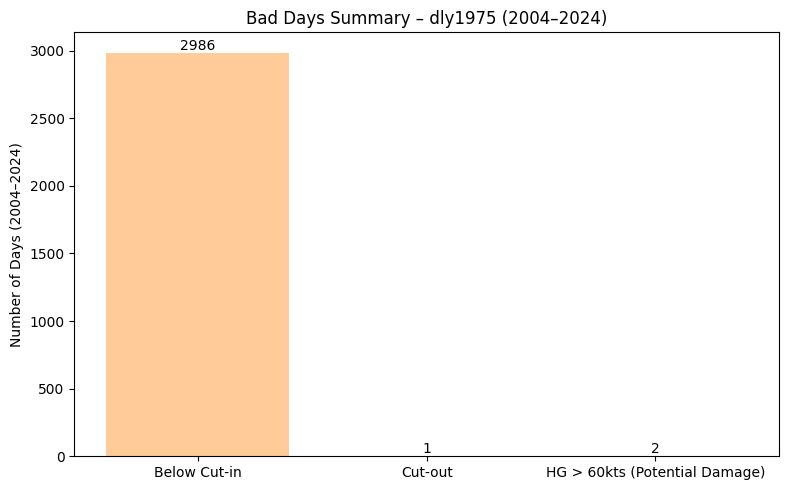


dly275: Days with hg > 60 kn = 117
Bad Days Summary:
Below Cut-in                     524
Cut-out                          207
HG > 60kts (Potential Damage)    117
dtype: int64


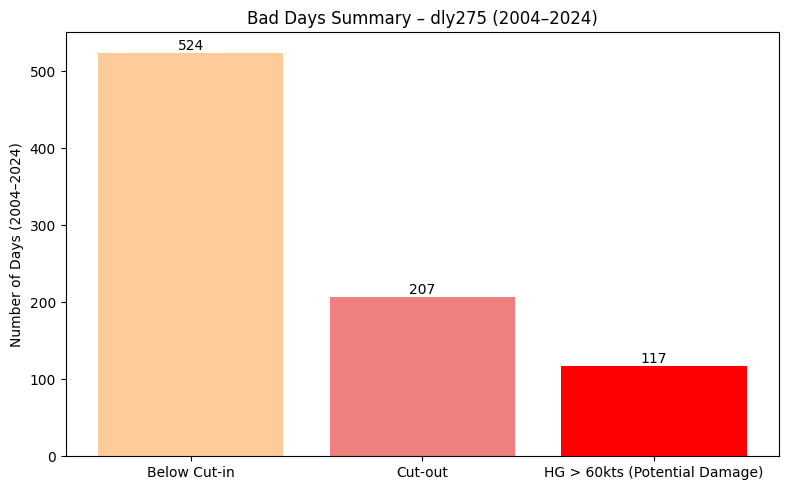


dly375: Days with hg > 60 kn = 4
Bad Days Summary:
Below Cut-in                     3015
Cut-out                             0
HG > 60kts (Potential Damage)       4
dtype: int64


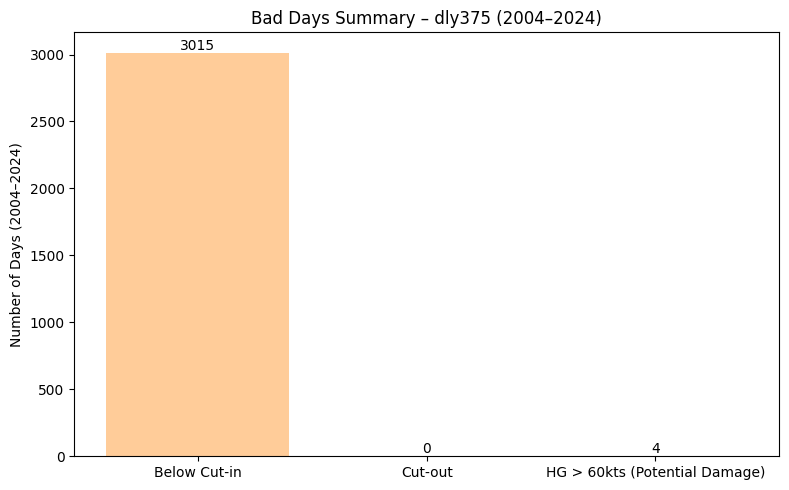


dly575: Days with hg > 60 kn = 2
Bad Days Summary:
Below Cut-in                     4364
Cut-out                             0
HG > 60kts (Potential Damage)       2
dtype: int64


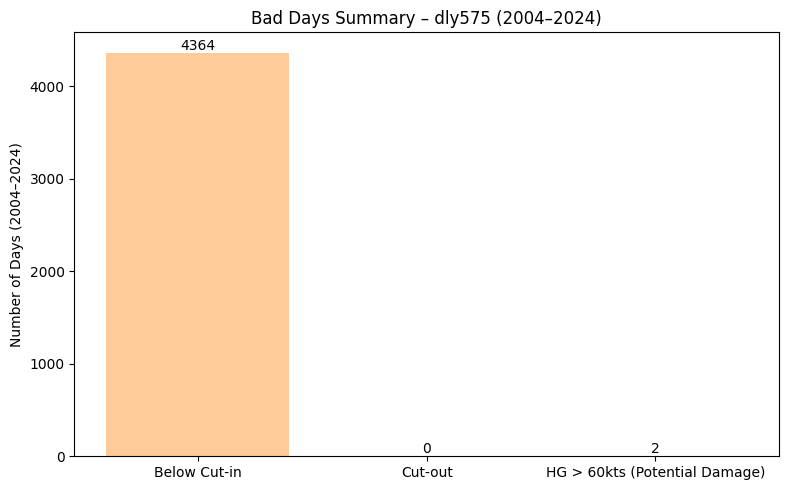


dly675: Days with hg > 60 kn = 2
Bad Days Summary:
Below Cut-in                     3850
Cut-out                             0
HG > 60kts (Potential Damage)       2
dtype: int64


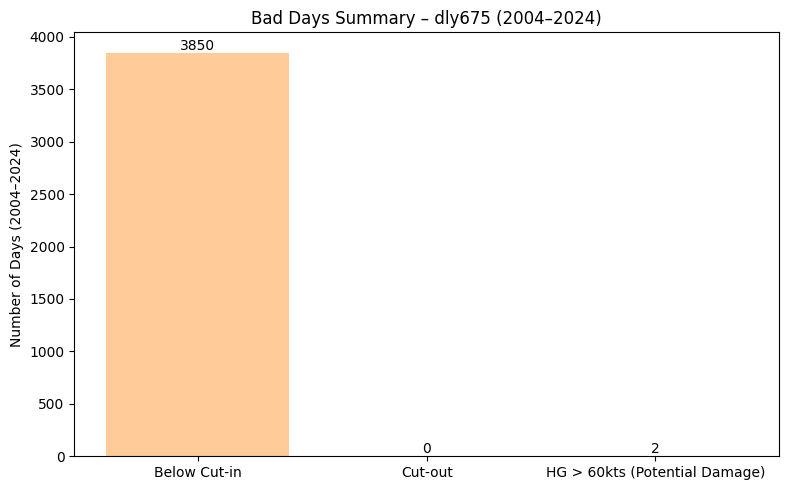


dly775: Days with hg > 60 kn = 53
Bad Days Summary:
Below Cut-in                     776
Cut-out                           53
HG > 60kts (Potential Damage)     53
dtype: int64


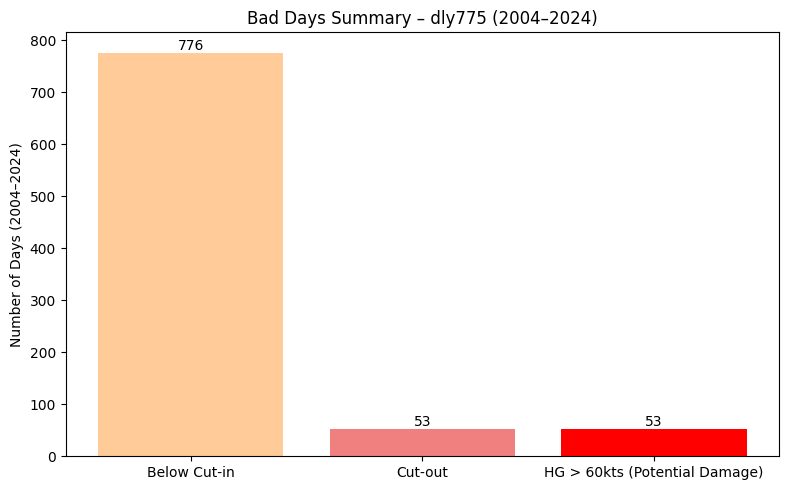


dly875: Days with hg > 60 kn = 0
Bad Days Summary:
Below Cut-in                     4016
Cut-out                             0
HG > 60kts (Potential Damage)       0
dtype: int64


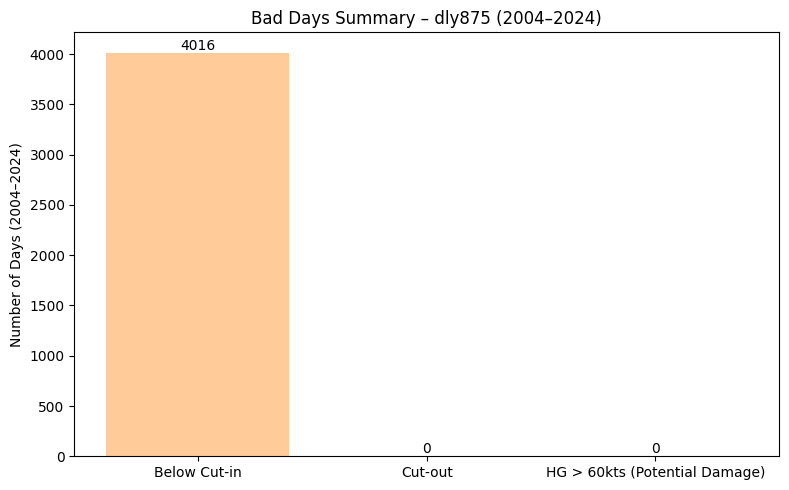

In [185]:
bad_days_results = plot_bad_days_all_stations(
    cleaned_daily_data,
    daily_threshold_results,
    gust_threshold=60
)


------------

**Function 8:** Summary and Pie Chart of Days Performance 

In [187]:
# Specific imports required for this function
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Function to plot daily pie charts
def plot_daily_pie_charts(
    summary_counts,
    days_hg_above,
    station_name
):
    """
    Produce two pie charts:
    1) Distribution of wind day types (thresholds + HG > 60)
    2) Percentage of days lost vs operational days

    Parameters
    ----------
    summary_counts : pandas.DataFrame
        Must contain a 'Count' column indexed by turbine thresholds
    days_hg_above : int
        Number of days with hg > 60 knots
    station_name : str
        Station name for plot titles
    """

    # =========================
    # PIE CHART 1: Day types
    # =========================
    pie_data = summary_counts["Count"].copy()
    pie_data.loc["HG > 60"] = days_hg_above

    colors_1 = [
        "#FFCC99",      # Below Cut-in
        "orange",       # Cut-in
        "lightgreen",   # Sub-optimal
        "green",        # Optimal
        "limegreen",    # Rated
        "lightcoral",   # Cut-out
        "red"           # HG > 60
    ]

    fig, ax = plt.subplots(figsize=(9, 9))

    wedges, _ = ax.pie(
        pie_data.values,
        startangle=90,
        colors=colors_1
    )

    total = pie_data.sum()
    percentages = pie_data.values / total * 100

    for i, wedge in enumerate(wedges):
        angle = (wedge.theta1 + wedge.theta2) / 2
        angle_rad = np.deg2rad(angle)

        x, y = np.cos(angle_rad), np.sin(angle_rad)
        label_x, label_y = 1.2 * x, 1.2 * y

        ax.plot([x, label_x], [y, label_y], color="gray", linewidth=0.8)
        ax.text(label_x, label_y, f"{percentages[i]:.1f}%", ha="center", va="center", fontsize=11)

    ax.legend(
        wedges,
        pie_data.index,
        title="Wind Threshold Categories (knots)",
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        fontsize=11
    )

    ax.set_title(
        f"Distribution of Day Types at {station_name} (2004–2024)",
        fontsize=14
    )

    plt.tight_layout()
    plt.show()

    # =========================
    # PIE CHART 2: Days lost
    # =========================
    total_days = summary_counts["Count"].sum()

    loss_percentages = {
        "Below Cut-in - No Energy": summary_counts.loc["Below Cut-in (<6)", "Count"] / total_days * 100,
        "Cut-out - Too Windy": summary_counts.loc["Cut-out (>29)", "Count"] / total_days * 100,
        "HG > 60kts (Potential Damage)": days_hg_above / total_days * 100
    }

    loss_percentages["Operational Days"] = 100 - sum(loss_percentages.values())

    labels = list(loss_percentages.keys())
    sizes = list(loss_percentages.values())

    colors_2 = ["orange", "lightcoral", "red", "green"]

    fig, ax = plt.subplots(figsize=(8, 8))

    wedges, _ = ax.pie(
        sizes,
        startangle=90,
        colors=colors_2
    )

    for i, wedge in enumerate(wedges):
        angle = (wedge.theta1 + wedge.theta2) / 2
        angle_rad = np.deg2rad(angle)

        x, y = np.cos(angle_rad), np.sin(angle_rad)
        label_x, label_y = 1.25 * x, 1.25 * y

        ax.plot([x, label_x], [y, label_y], color="gray", linewidth=0.8)
        ax.text(label_x, label_y, f"{sizes[i]:.1f}%", ha="center", va="center", fontsize=11)

    ax.legend(
        wedges,
        labels,
        title="Day Classification",
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        fontsize=11
    )

    ax.set_title(
        f"Percentage of Days Lost vs Operational Days – {station_name} (2004–2024)",
        fontsize=14
    )

    plt.tight_layout()
    plt.show()


In [188]:
def plot_daily_pie_charts_all_stations(
    daily_threshold_results,
    bad_days_results
):
    """
    Produce daily pie charts for all stations.
    """

    for station_name in daily_threshold_results:
        summary_counts = (
            daily_threshold_results[station_name][0]
            .to_frame(name="Count")
        )

        days_hg_above = bad_days_results[station_name].iloc[-1]

        plot_daily_pie_charts(
            summary_counts=summary_counts,
            days_hg_above=days_hg_above,
            station_name=station_name
        )


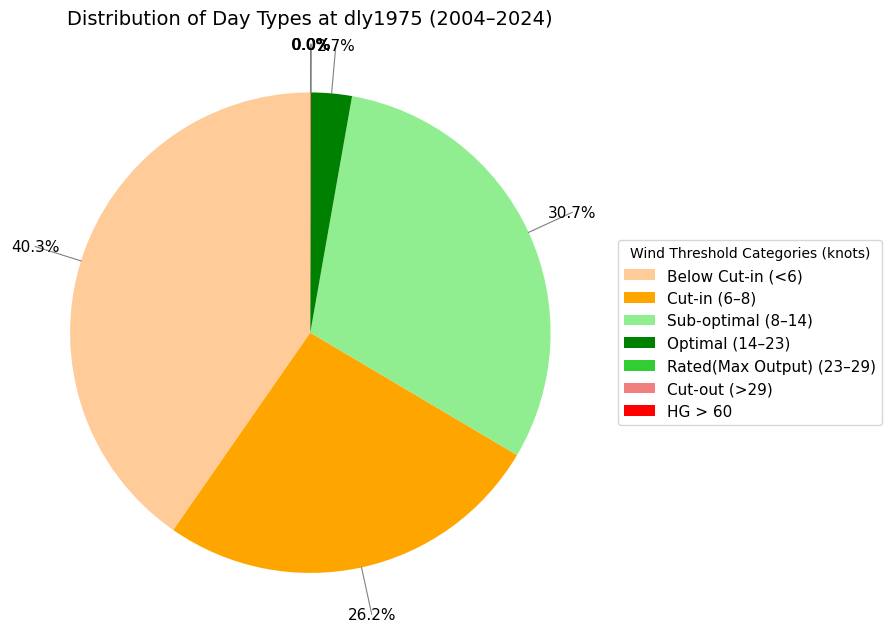

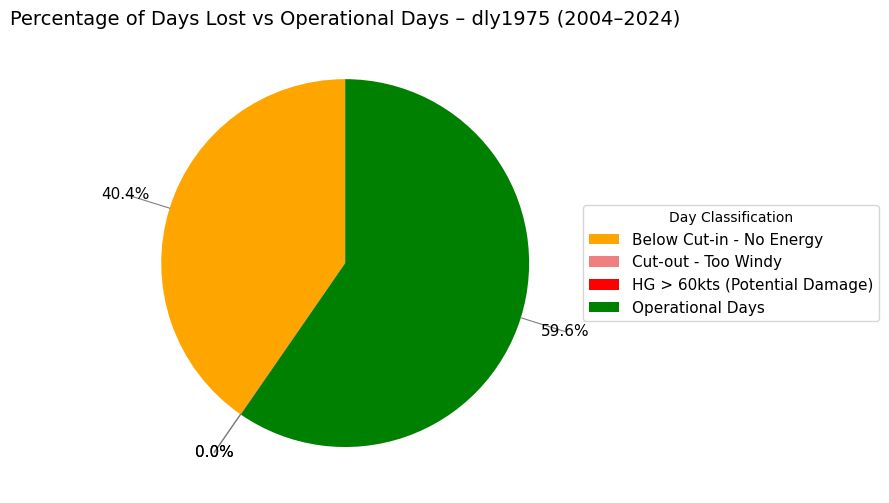

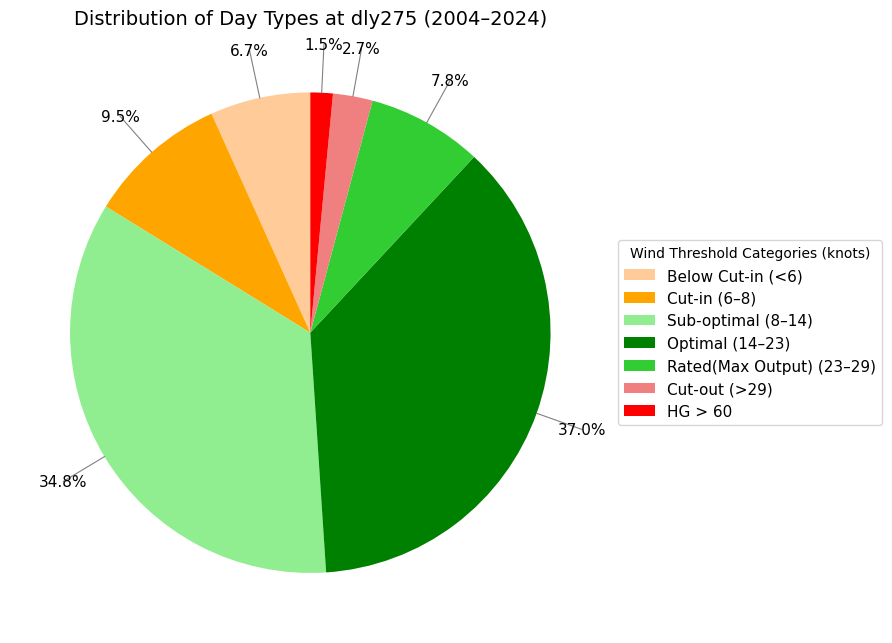

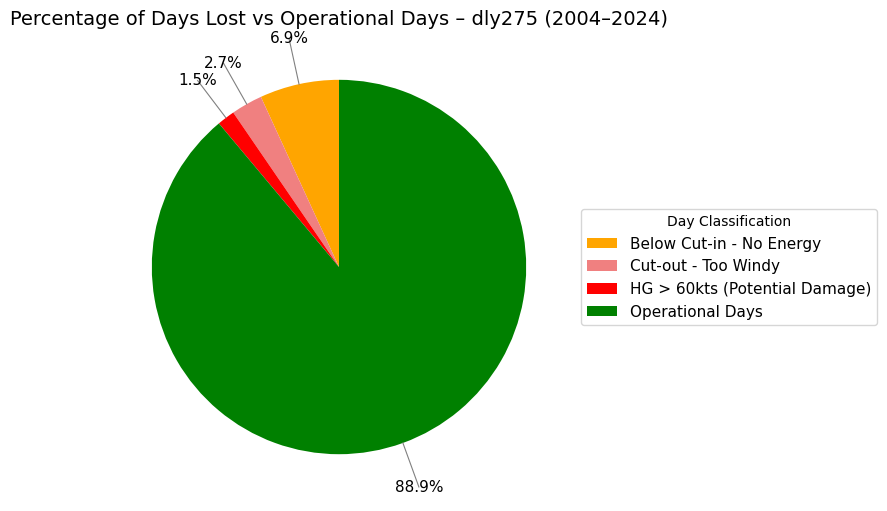

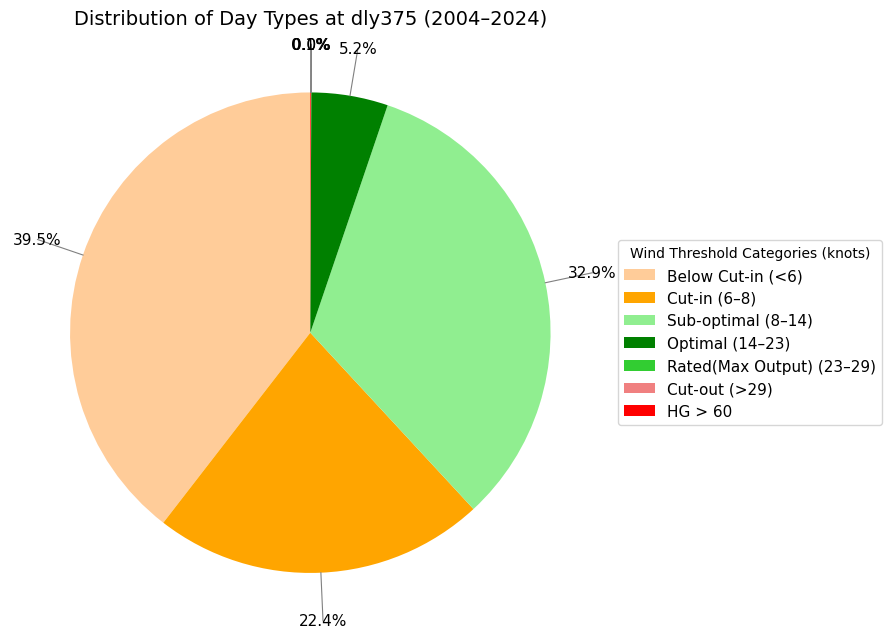

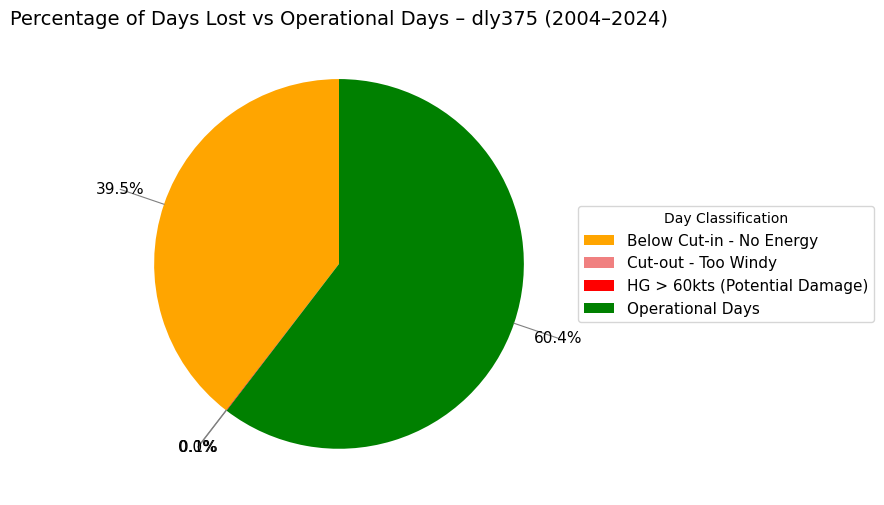

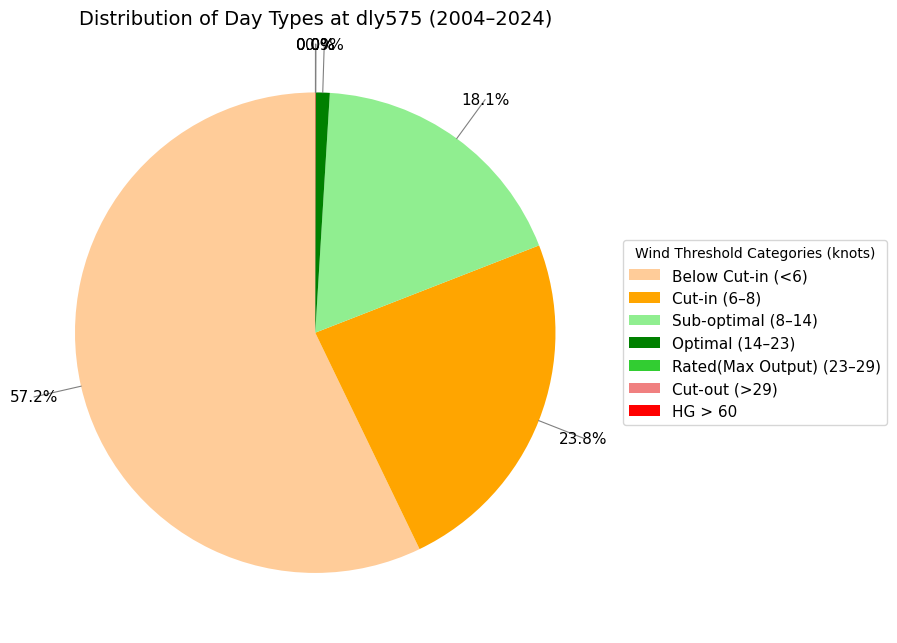

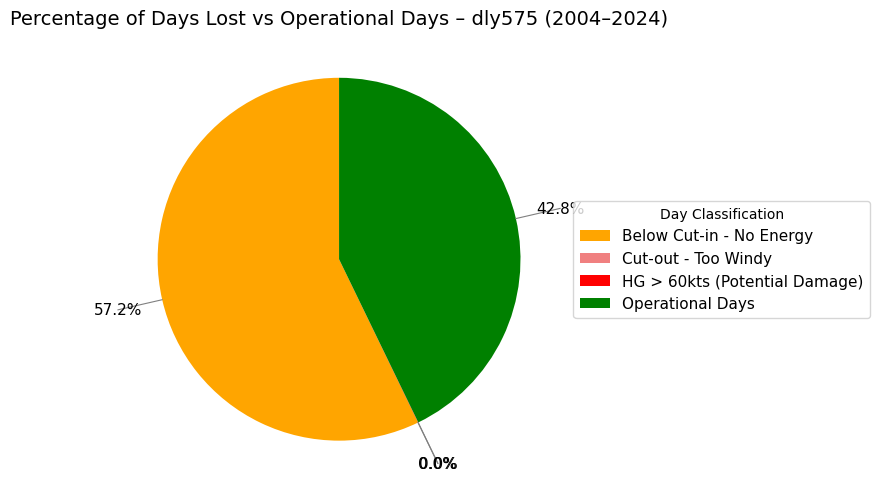

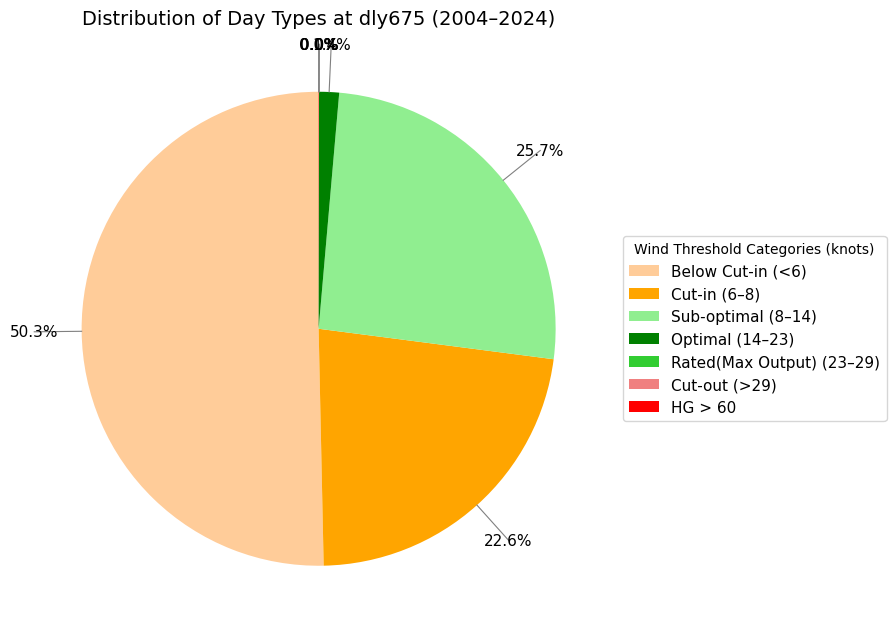

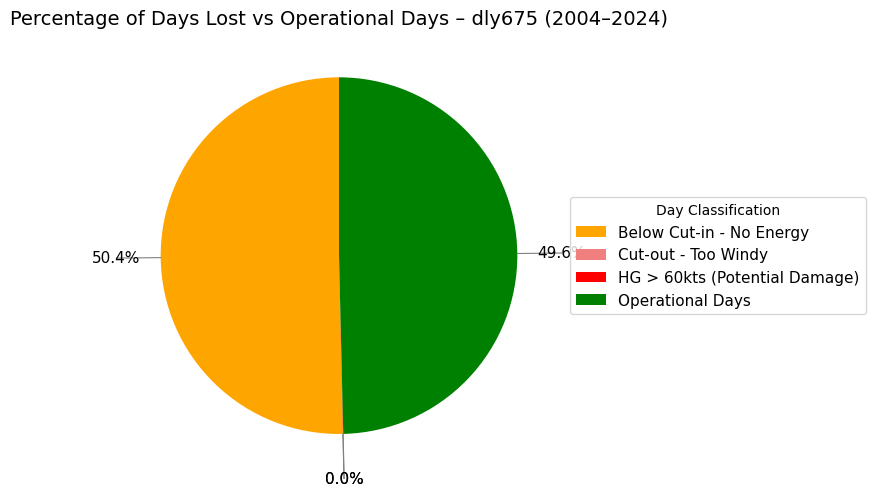

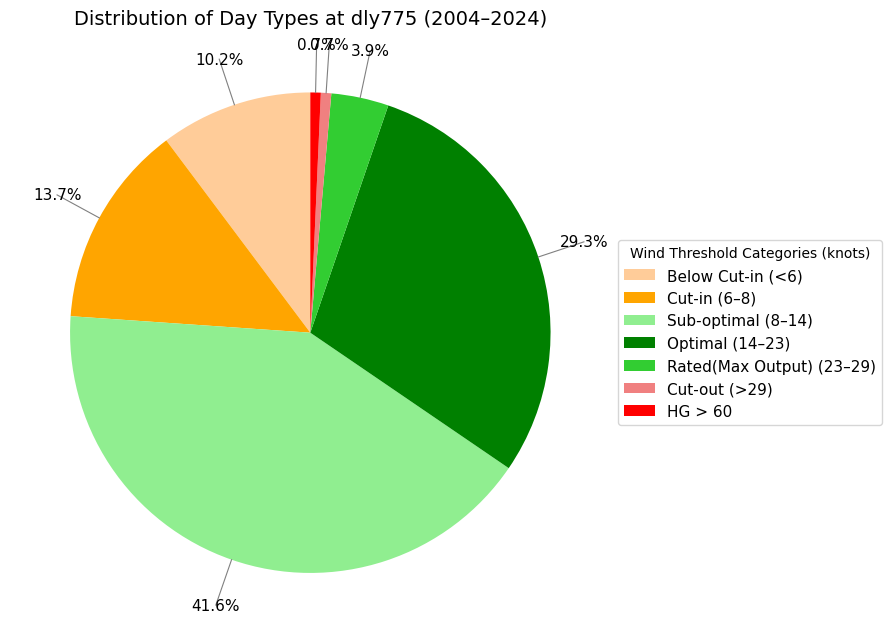

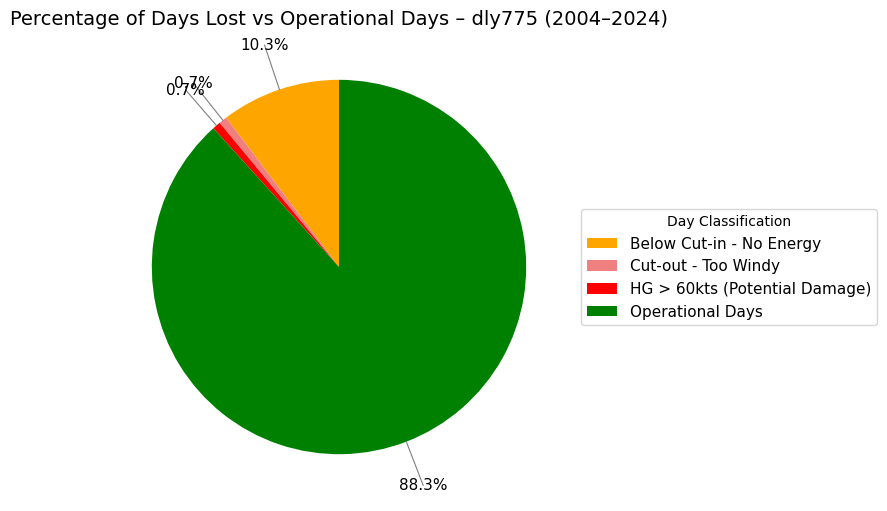

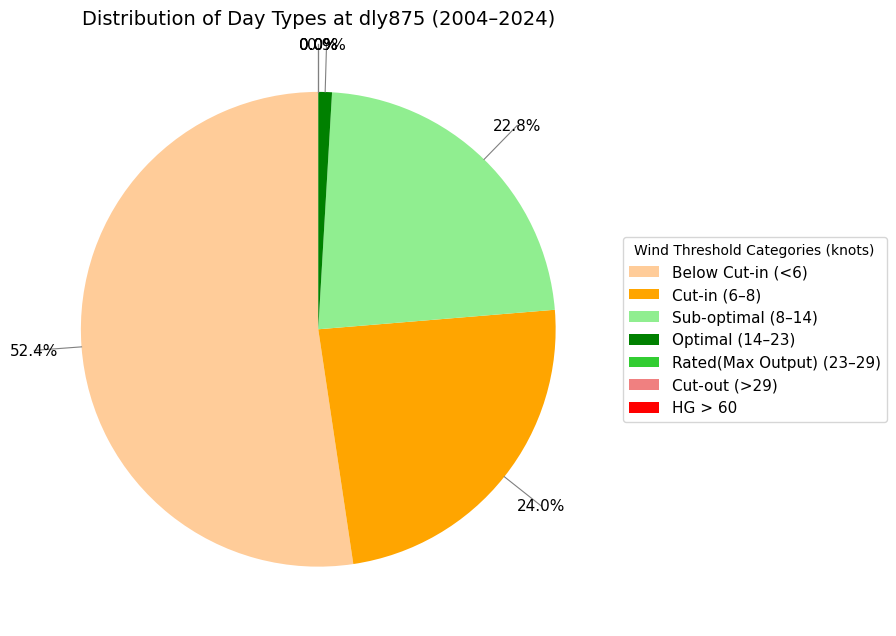

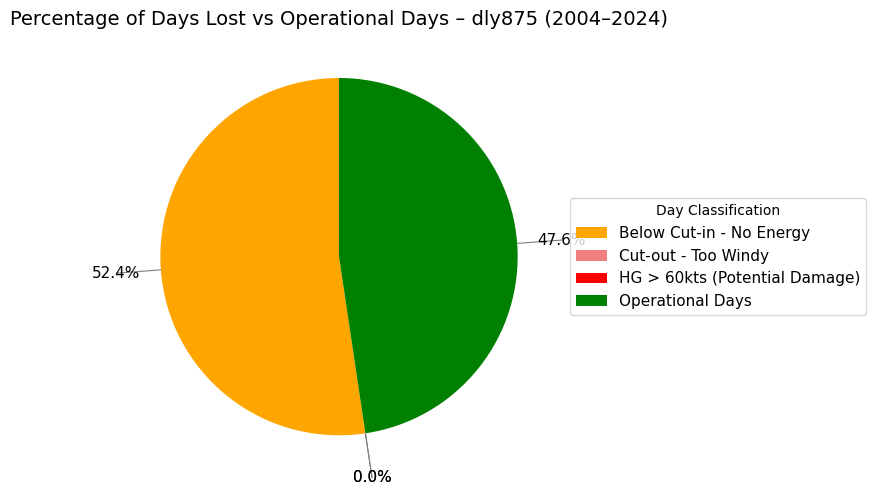

In [189]:
plot_daily_pie_charts_all_stations(
    daily_threshold_results,
    bad_days_results
)


-------------

**Function 9** Potential Energy Output

In [190]:
# Specific imports required for this function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to estimate and plot annual wind energy
def estimate_and_plot_annual_wind_energy(
    daily_df,
    station_name,
    start_date="2004-01-01",
    end_date="2025-01-01"
):
    """
    Estimate annual wind energy production from daily wind speed data
    and compare against industry benchmarks.

    Parameters
    ----------
    daily_df : pandas.DataFrame
        Cleaned daily data with columns: date, wdsp
    station_name : str
        Station name for plot titles
    start_date : str
        Start date for analysis
    end_date : str
        End date for analysis

    Returns
    -------
    operating_df : pandas.DataFrame
        Daily data used for energy estimation
    annual_energy_GWh : pandas.DataFrame
        Annual energy production in GWh
    """

    # =========================
    # 1. Filter operational range
    # =========================
    operating_df = (
        daily_df
        .loc[
            (daily_df["date"] >= start_date) &
            (daily_df["date"] < end_date) &
            (daily_df["wdsp"] >= 6) &
            (daily_df["wdsp"] <= 29)
        ]
        .copy()
    )

    # =========================
    # 2. Convert wind speed to m/s
    # =========================
    operating_df["wdsp_ms"] = operating_df["wdsp"] * 0.514444

    # =========================
    # 3. Power & energy calculation
    # =========================
    rho = 1.225    # kg/m^3
    A = 7854       # m^2 (100 m rotor diameter)
    Cp = 0.593     # Betz limit

    operating_df["power_W"] = (
        0.5 * rho * A * Cp * operating_df["wdsp_ms"] ** 3
    )

    operating_df["energy_MWh_day"] = (
        operating_df["power_W"] * 24 / 1e6
    )

    # =========================
    # 4. Annual aggregation
    # =========================
    operating_df["year"] = operating_df["date"].dt.year

    annual_energy_GWh = (
        operating_df
        .groupby("year", as_index=False)["energy_MWh_day"]
        .sum()
    )

    annual_energy_GWh["energy_GWh"] = (
        annual_energy_GWh["energy_MWh_day"] / 1000
    )

    annual_energy_GWh = annual_energy_GWh[["year", "energy_GWh"]]

    print("\nAnnual Energy Production (GWh):")
    print(annual_energy_GWh)

    # =========================
    # 5. Industry benchmarks
    # =========================
    Poor = 6.6
    Ind_Average = 7.9
    Good = 9.2
    Excellent = 10.5

    bar_colors = []
    for value in annual_energy_GWh["energy_GWh"]:
        if value < Poor:
            bar_colors.append("red")
        elif value < Ind_Average:
            bar_colors.append("orange")
        elif value < Good:
            bar_colors.append("lightgreen")
        elif value < Excellent:
            bar_colors.append("green")
        else:
            bar_colors.append("blue")

    # =========================
    # 6. Plot
    # =========================
    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        annual_energy_GWh["year"],
        annual_energy_GWh["energy_GWh"],
        color=bar_colors,
        label="Estimated Annual Energy"
    )

    plt.axhline(Poor, color="red", linestyle="dotted", label="Poor (6.6 GWh)")
    plt.axhline(Ind_Average, color="orange", linestyle="dotted", label="Industry Avg (7.9 GWh)")
    plt.axhline(Good, color="green", linestyle="dotted", label="Good (9.2 GWh)")
    plt.axhline(Excellent, color="blue", linestyle="dotted", label="Excellent (10.5 GWh)")

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=8
        )

    plt.xlabel("Year")
    plt.ylabel("Annual Energy Production (GWh)")
    plt.title(f"Estimated Annual Wind Energy Production – {station_name}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return operating_df, annual_energy_GWh



Annual Energy Production (GWh):
    year  energy_GWh
0   2004    1.067208
1   2005    2.954033
2   2006    2.785755
3   2007    2.491302
4   2008    2.786556
5   2009    2.098067
6   2010    1.347123
7   2011    2.354070
8   2012    1.736763
9   2013    2.096993
10  2014    1.690465
11  2015    2.022546
12  2016    1.410251
13  2017    1.436216
14  2018    1.491939
15  2019    1.345411
16  2020    1.577073
17  2021    1.015671
18  2022    1.096505
19  2023    0.945392
20  2024    1.072774


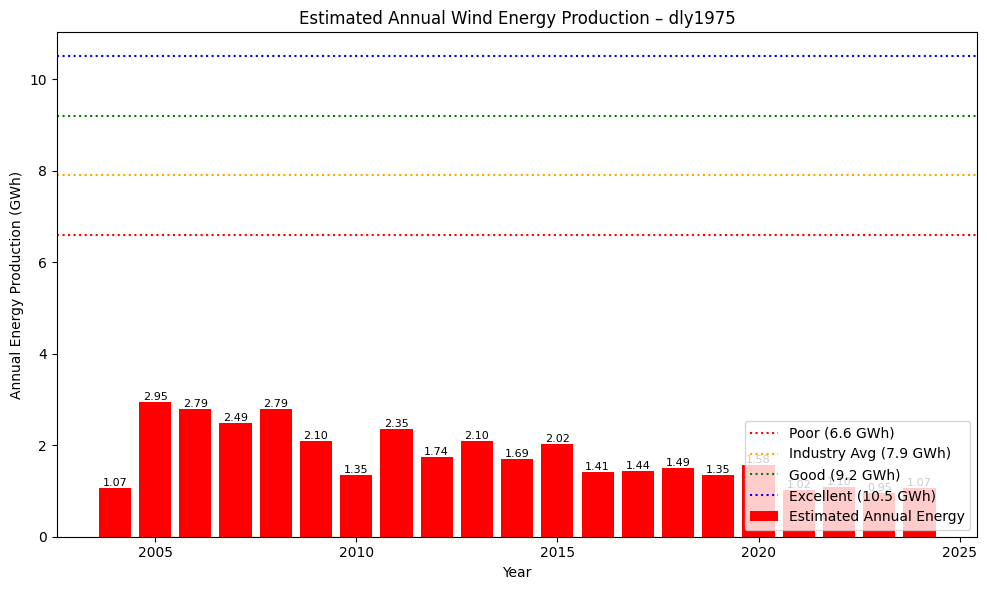


Annual Energy Production (GWh):
    year  energy_GWh
0   2004   14.795760
1   2005   12.336789
2   2006   12.959281
3   2007   12.762803
4   2008   14.470355
5   2009   13.256058
6   2010    9.288479
7   2011   17.262050
8   2012   13.359983
9   2013   14.377886
10  2014   13.752958
11  2015   16.146990
12  2016   13.621191
13  2017   14.095233
14  2018   13.833147
15  2019   15.022739
16  2020   16.417764
17  2021   12.159498
18  2022   15.383459
19  2023   15.121274
20  2024   12.434251


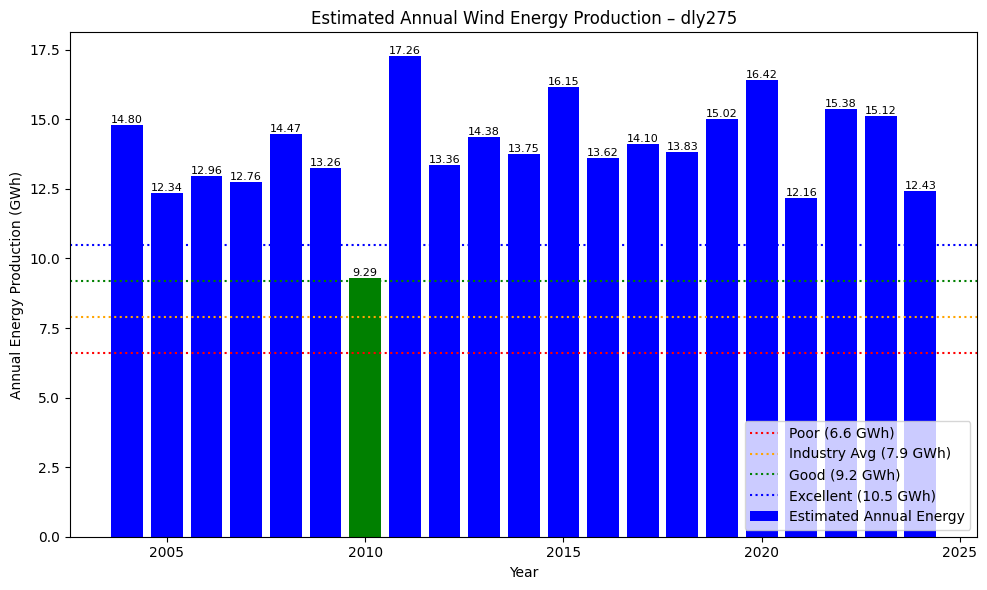


Annual Energy Production (GWh):
    year  energy_GWh
0   2004    2.214655
1   2005    2.428502
2   2006    2.379012
3   2007    2.357263
4   2008    2.479085
5   2009    2.387581
6   2010    1.357977
7   2011    2.591991
8   2012    1.796318
9   2013    2.486491
10  2014    2.398216
11  2015    3.237625
12  2016    2.044388
13  2017    2.021468
14  2018    2.193362
15  2019    2.293674
16  2020    3.132405
17  2021    1.997390
18  2022    2.243303
19  2023    2.146633
20  2024    2.137556


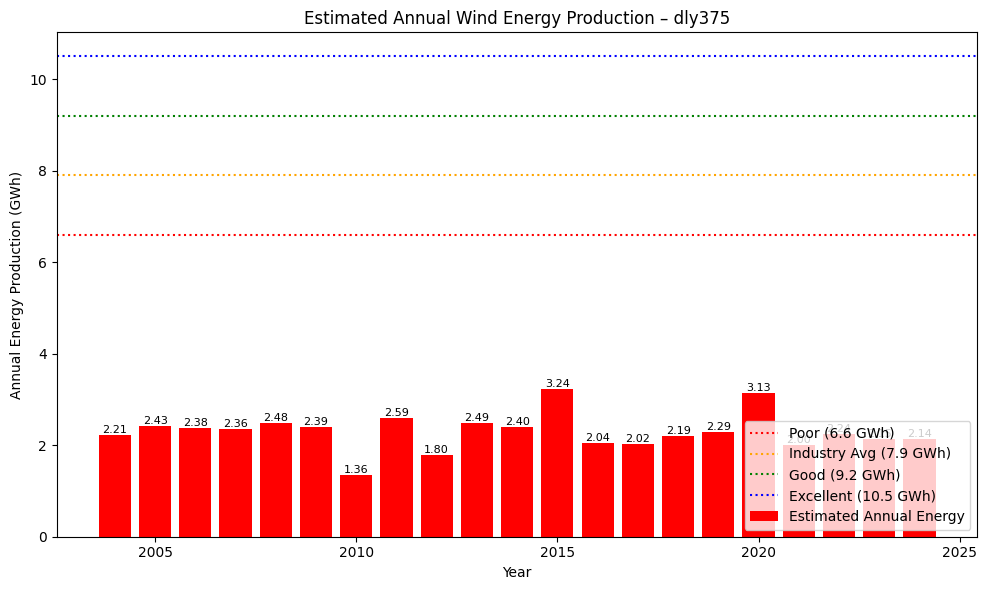


Annual Energy Production (GWh):
    year  energy_GWh
0   2004    1.051168
1   2005    1.010501
2   2006    0.981306
3   2007    0.896986
4   2008    1.060327
5   2009    0.816566
6   2010    0.571939
7   2011    1.045768
8   2012    0.783647
9   2013    1.125575
10  2014    0.991393
11  2015    1.277224
12  2016    0.908262
13  2017    1.112581
14  2018    1.106414
15  2019    1.170408
16  2020    1.250532
17  2021    0.951309
18  2022    0.977364
19  2023    0.891976
20  2024    0.967104


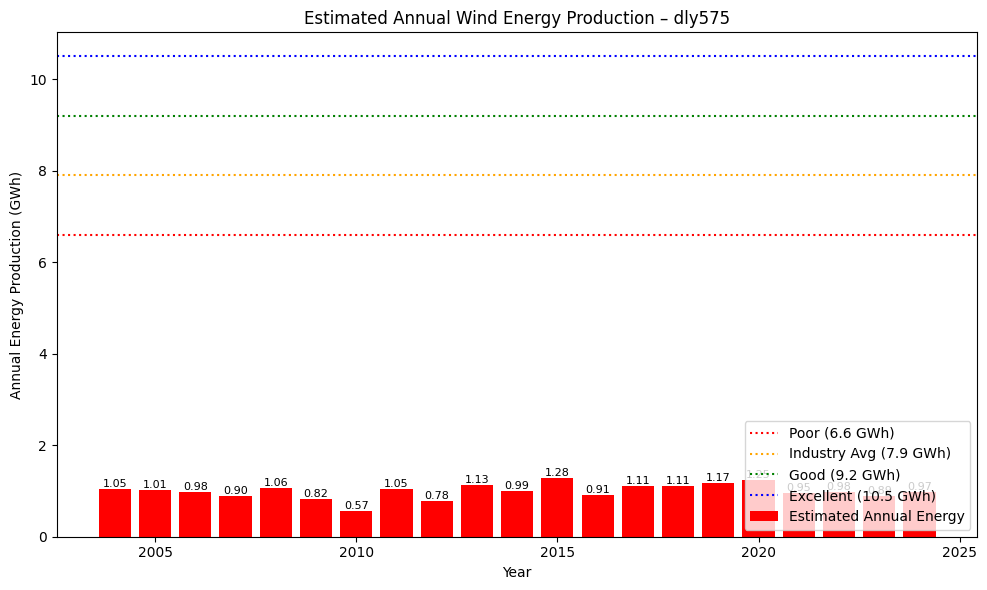


Annual Energy Production (GWh):
    year  energy_GWh
0   2004    1.765824
1   2005    1.731332
2   2006    1.765338
3   2007    1.552179
4   2008    1.677688
5   2009    1.425196
6   2010    0.858967
7   2011    1.818413
8   2012    1.228018
9   2013    1.457640
10  2014    1.312124
11  2015    1.741454
12  2016    1.129953
13  2017    1.063701
14  2018    1.312484
15  2019    1.084570
16  2020    1.455870
17  2021    0.851783
18  2022    1.085309
19  2023    0.873010
20  2024    0.977664


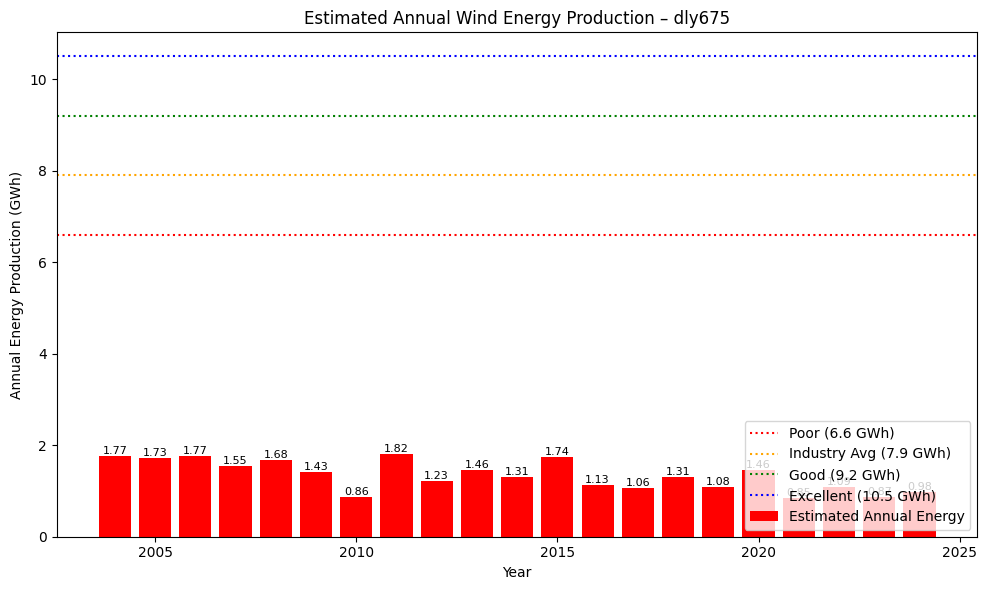


Annual Energy Production (GWh):
    year  energy_GWh
0   2004    5.573460
1   2005    9.157775
2   2006    9.665791
3   2007    9.291713
4   2008   10.213070
5   2009   10.099357
6   2010    5.977044
7   2011   10.727109
8   2012    9.219673
9   2013   10.783159
10  2014   10.276399
11  2015   12.532710
12  2016    9.539191
13  2017    9.430843
14  2018   10.335952
15  2019   10.540576
16  2020   12.389323
17  2021    8.502497
18  2022   10.624020
19  2023   10.246010
20  2024    8.814030


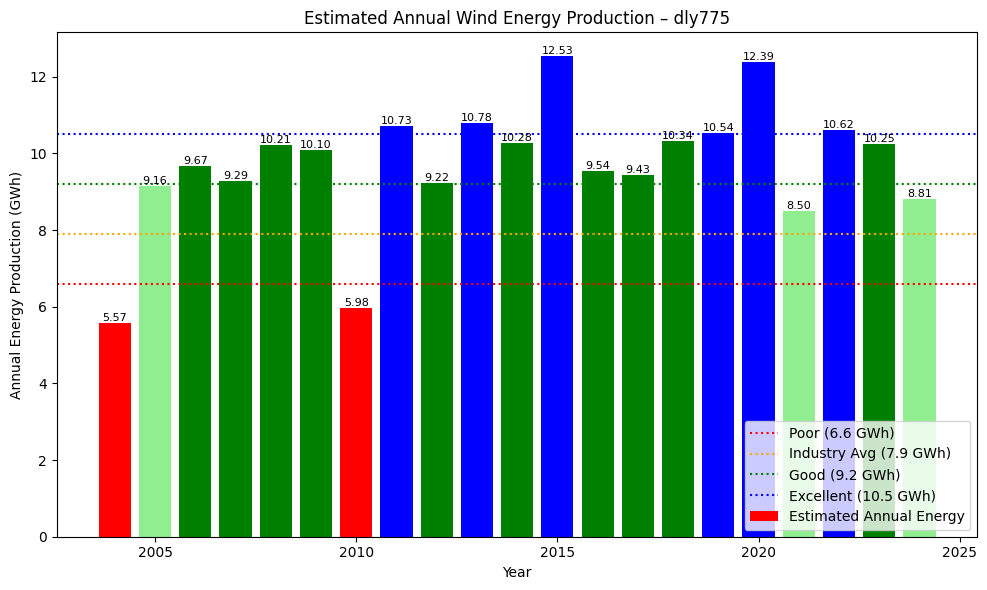


Annual Energy Production (GWh):
    year  energy_GWh
0   2004    1.563127
1   2005    1.561010
2   2006    1.578115
3   2007    1.327651
4   2008    1.387419
5   2009    1.046199
6   2010    0.612622
7   2011    1.354297
8   2012    0.914831
9   2013    1.152702
10  2014    1.061566
11  2015    1.431056
12  2016    0.914499
13  2017    0.972976
14  2018    1.144012
15  2019    1.001284
16  2020    1.374901
17  2021    0.889607
18  2022    1.078124
19  2023    0.962104
20  2024    1.039838


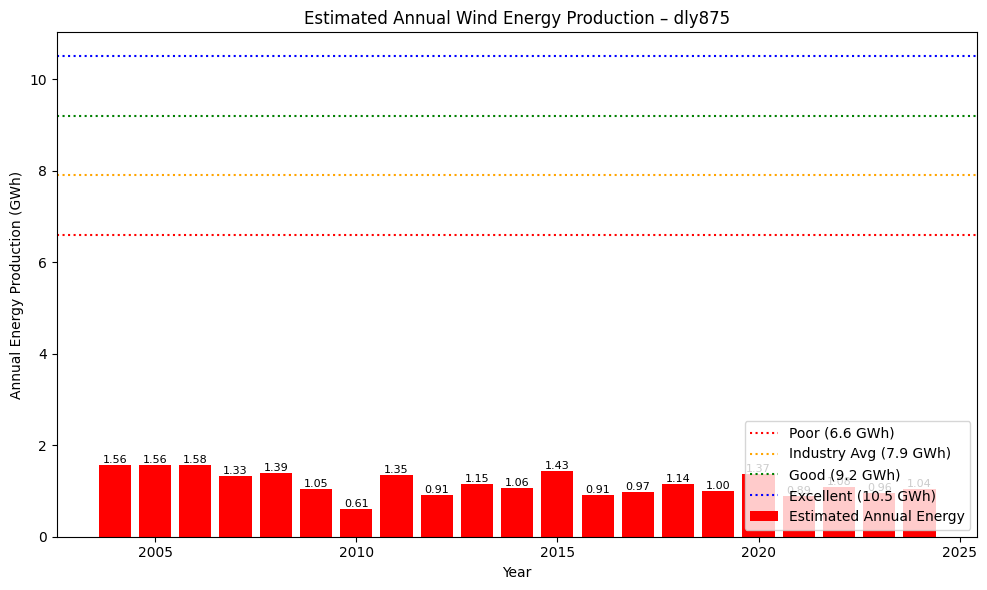

In [191]:
energy_results = {}

for station_name, daily_df in cleaned_daily_data.items():
    energy_results[station_name] = estimate_and_plot_annual_wind_energy(
        daily_df,
        station_name=station_name
    )


-----------

**Function 10** How Many Pots of Tea

In [197]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

def plot_pots_of_tea_equivalent(
    annual_energy_GWh,
    station_name,
    image_path,
    kettle_kwh=0.25
):
    """
    Convert total wind energy into an equivalent number of pots of tea
    and overlay the result on an image.

    Parameters
    ----------
    annual_energy_GWh : pandas.DataFrame
        Must contain column 'energy_GWh'
    station_name : str
        Station name to display on image
    image_path : str
        Path to background image
    kettle_kwh : float
        Energy required per kettle boil (default = 0.25 kWh)

    Returns
    -------
    results : dict
        Dictionary containing total energy and number of pots of tea
    """

    # =========================
    # Energy calculations
    # =========================
    total_energy_gwh = annual_energy_GWh["energy_GWh"].sum()
    total_energy_wh = total_energy_gwh * 1e9  # GWh → Wh

    number_of_pots_tea = total_energy_wh / kettle_kwh

    print(f"{station_name}: Total Energy (GWh, 2004–2024): {total_energy_gwh:.2f}")
    print(f"{station_name}: Pots of Tea Makeable: {number_of_pots_tea:,.0f}")

    # =========================
    # Image overlay
    # =========================
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)

    main_text = f"{number_of_pots_tea:,.0f}\nPots of Tea"
    bottom_title = station_name

    # Fonts (large values may not render if font fallback is used)
    try:
        main_font = ImageFont.truetype("DejaVuSans-Bold.ttf", 180)
        title_font = ImageFont.truetype("DejaVuSans-Bold.ttf", 90)
    except:
        main_font = ImageFont.load_default()
        title_font = ImageFont.load_default()

    width, height = img.size

    # Position main text (top-right)
    x = int(width * 0.72)
    y = int(height * 0.12)

    # Draw main text with outline
    draw.text((x + 3, y + 3), main_text, font=main_font, fill="white")
    draw.text((x, y), main_text, font=main_font, fill="black")

    # Bottom-centre title
    title_bbox = draw.textbbox((0, 0), bottom_title, font=title_font)
    title_width = title_bbox[2] - title_bbox[0]

    title_x = (width - title_width) // 2
    title_y = height - int(height * 0.1)

    draw.text((title_x + 2, title_y + 2), bottom_title, font=title_font, fill="white")
    draw.text((title_x, title_y), bottom_title, font=title_font, fill="black")

    # Display
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    return {
        "total_energy_GWh": total_energy_gwh,
        "pots_of_tea": number_of_pots_tea
    }


dly1975: Total Energy (GWh, 2004–2024): 36.82
dly1975: Pots of Tea Makeable: 147,288,447,895


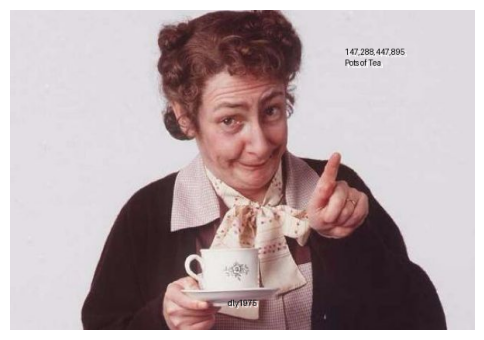

dly275: Total Energy (GWh, 2004–2024): 292.86
dly275: Pots of Tea Makeable: 1,171,431,789,854


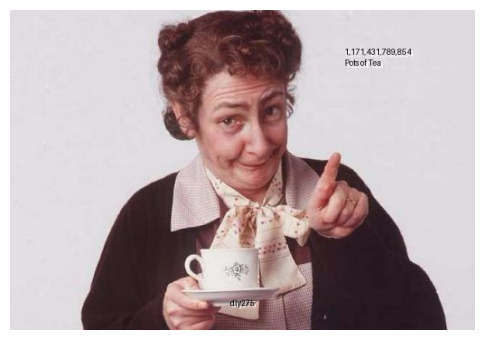

dly375: Total Energy (GWh, 2004–2024): 48.32
dly375: Pots of Tea Makeable: 193,299,583,460


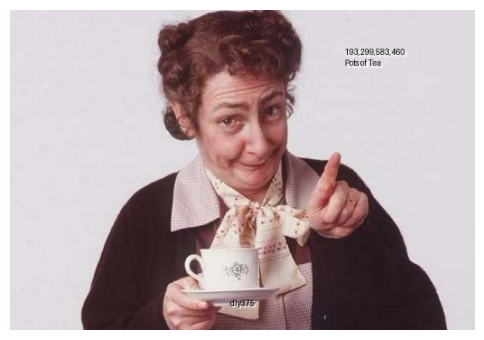

dly575: Total Energy (GWh, 2004–2024): 20.95
dly575: Pots of Tea Makeable: 83,793,405,475


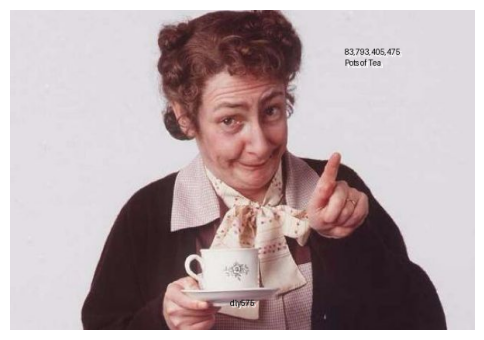

dly675: Total Energy (GWh, 2004–2024): 28.17
dly675: Pots of Tea Makeable: 112,674,071,468


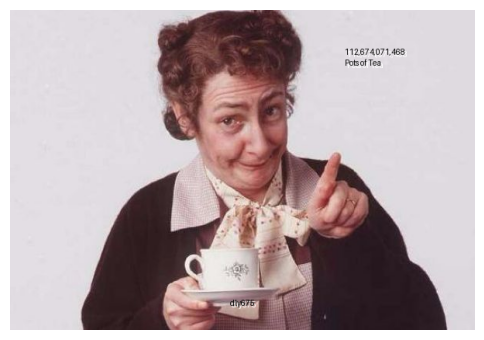

dly775: Total Energy (GWh, 2004–2024): 203.94
dly775: Pots of Tea Makeable: 815,758,805,439


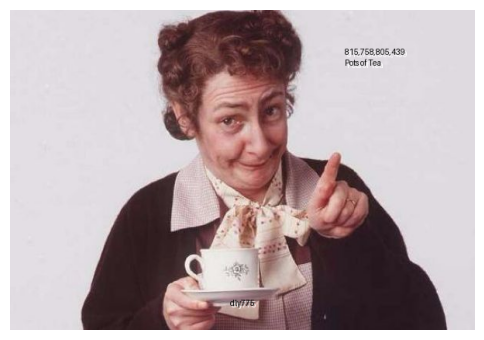

dly875: Total Energy (GWh, 2004–2024): 24.37
dly875: Pots of Tea Makeable: 97,471,761,842


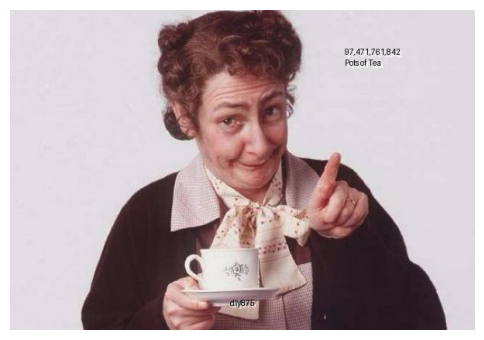

In [199]:
tea_results = {}

for station_name, (_, annual_energy_df) in energy_results.items():
    tea_results[station_name] = plot_pots_of_tea_equivalent(
        annual_energy_GWh=annual_energy_df,
        station_name=station_name,
        image_path=r"C:\AlecProjects\PFDA_2025_Project-\ImagesforHumour\Mrs Doyle Tea.jpg"
    )


--------

#### Conclusion 